In [30]:
import pandas as pd
df= pd.read_csv(r"C:\Users\Access\Documents\AI ROBOT\XAUUSD_Candlestick_1_M_BID_2020-1-1_2024-12-31.csv")

import pandas as pd

# --- دالة تجميع إلى 15 دقيقة ---
def resample_to_15min(df):
    df['Gmt time'] = pd.to_datetime(df['Gmt time'])
    df.set_index('Gmt time', inplace=True)

    df_15min = df.resample('15T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()

    df_15min.reset_index(inplace=True)
    return df_15min

# --- دالة Heikin Ashi ---
def heikin_ashi(df):
    ha_df = pd.DataFrame()
    ha_df['Gmt time'] = df['Gmt time']
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    ha_open = [(df['Open'].iloc[0] + df['Close'].iloc[0]) / 2]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i - 1] + ha_df['Close'].iloc[i - 1]) / 2)

    ha_df['Open'] = ha_open
    ha_df['High'] = pd.concat([df['High'], ha_df['Open'], ha_df['Close']], axis=1).max(axis=1)
    ha_df['Low'] = pd.concat([df['Low'], ha_df['Open'], ha_df['Close']], axis=1).min(axis=1)
    ha_df['Volume'] = df['Volume']
    return ha_df[['Gmt time', 'Open', 'High', 'Low', 'Close']]

# --- تشغيل الخطوات ---
df_15min = resample_to_15min(df)
ha_df = heikin_ashi(df_15min)

# --- طباعة النتيجة ---
print(ha_df.head(10))  # اطبع أول 10 صفوف
df = ha_df

C:\Users\Access\AppData\Local\Temp\ipykernel_25268\4091096043.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample('15T').agg({


             Gmt time      Open      High       Low     Close  Volume
0 2020-01-01 00:00:00  1516.915  1516.915  1516.915  1516.915     0.0
1 2020-01-01 00:15:00  1516.915  1516.915  1516.915  1516.915     0.0
2 2020-01-01 00:30:00  1516.915  1516.915  1516.915  1516.915     0.0
3 2020-01-01 00:45:00  1516.915  1516.915  1516.915  1516.915     0.0
4 2020-01-01 01:00:00  1516.915  1516.915  1516.915  1516.915     0.0
5 2020-01-01 01:15:00  1516.915  1516.915  1516.915  1516.915     0.0
6 2020-01-01 01:30:00  1516.915  1516.915  1516.915  1516.915     0.0
7 2020-01-01 01:45:00  1516.915  1516.915  1516.915  1516.915     0.0
8 2020-01-01 02:00:00  1516.915  1516.915  1516.915  1516.915     0.0
9 2020-01-01 02:15:00  1516.915  1516.915  1516.915  1516.915     0.0


In [32]:
df

Gmt time         Open      High          Low     Close  \
0      2020-01-01 00:00:00  1516.915000  1516.915  1516.915000  1516.915   
1      2020-01-01 00:15:00  1516.915000  1516.915  1516.915000  1516.915   
2      2020-01-01 00:30:00  1516.915000  1516.915  1516.915000  1516.915   
3      2020-01-01 00:45:00  1516.915000  1516.915  1516.915000  1516.915   
4      2020-01-01 01:00:00  1516.915000  1516.915  1516.915000  1516.915   
...                    ...          ...       ...          ...       ...   
158248 2024-12-31 22:45:00  2624.227034  2624.255  2624.227034  2624.255   
158249 2024-12-31 23:00:00  2624.241017  2624.255  2624.241017  2624.255   
158250 2024-12-31 23:15:00  2624.248008  2624.255  2624.248008  2624.255   
158251 2024-12-31 23:30:00  2624.251504  2624.255  2624.251504  2624.255   
158252 2024-12-31 23:45:00  2624.253252  2624.255  2624.253252  2624.255   

        Volume  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
158248     0.0  
158249     0.0  
158250     0.0  
158251     0.0  
158252     0.0  

[158253 rows x 6 columns]

In [34]:
df.to_csv("heikin_ashi-gold.csv", index=False)


In [33]:
ha_df.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [11]:
def generate_strict_signals(df, steps_ahead=5, min_target_points=5.0, rr_ratio=4.0):
    signals = []
    take_profits = []
    stop_losses = []
    
    close = df['Close'].values
    high = df['High'].values
    low = df['Low'].values
    times = pd.to_datetime(df['Gmt time']).values

    for i in range(len(df) - steps_ahead):
        entry_price = close[i]
        entry_day = pd.to_datetime(times[i]).date()
        future_day = pd.to_datetime(times[i + steps_ahead]).date()

        # نحذف الصفقات التي تمتد ليوم آخر
        if entry_day != future_day:
            signals.append(0)
            take_profits.append(None)
            stop_losses.append(None)
            continue

        signal = 0
        tp = None
        sl = None

        future_close = close[i + steps_ahead]
        future_high = high[i+1 : i+steps_ahead+1]
        future_low = low[i+1 : i+steps_ahead+1]

        # ---- صفقة شراء ----
        if future_close > entry_price:
            min_low = future_low.min()
            retraced = min_low < entry_price  # هل حدث انعكاس؟
            target = future_close - entry_price
            if not retraced and target >= min_target_points:
                signal = 1
                tp = entry_price + target
                sl = entry_price - (target / rr_ratio)

        # ---- صفقة بيع ----
        elif future_close < entry_price:
            max_high = future_high.max()
            retraced = max_high > entry_price
            target = entry_price - future_close
            if not retraced and target >= min_target_points:
                signal = -1
                tp = entry_price - target
                sl = entry_price + (target / rr_ratio)

        signals.append(signal)
        take_profits.append(tp)
        stop_losses.append(sl)

    # ملء باقي الشموع بإشارات 0 وقيم None
    for _ in range(steps_ahead):
        signals.append(0)
        take_profits.append(None)
        stop_losses.append(None)

    df['Signal'] = signals
    df['Take_Profit'] = take_profits
    df['Stop_Loss'] = stop_losses

    return df


In [12]:
ha_df = generate_strict_signals(
    ha_df,
    steps_ahead=5,           # أي بعد 75 دقيقة (15 * 5)
    min_target_points=5.0,   # لا نقبل أهداف أقل من 50 نقطة
    rr_ratio=4.0             # نسبة ربح/خسارة 1:4
)


In [29]:
ha_df

Gmt time         Open      High          Low     Close  \
0      2020-01-01 00:00:00  1516.915000  1516.915  1516.915000  1516.915   
1      2020-01-01 00:15:00  1516.915000  1516.915  1516.915000  1516.915   
2      2020-01-01 00:30:00  1516.915000  1516.915  1516.915000  1516.915   
3      2020-01-01 00:45:00  1516.915000  1516.915  1516.915000  1516.915   
4      2020-01-01 01:00:00  1516.915000  1516.915  1516.915000  1516.915   
...                    ...          ...       ...          ...       ...   
158248 2024-12-31 22:45:00  2624.227034  2624.255  2624.227034  2624.255   
158249 2024-12-31 23:00:00  2624.241017  2624.255  2624.241017  2624.255   
158250 2024-12-31 23:15:00  2624.248008  2624.255  2624.248008  2624.255   
158251 2024-12-31 23:30:00  2624.251504  2624.255  2624.251504  2624.255   
158252 2024-12-31 23:45:00  2624.253252  2624.255  2624.253252  2624.255   

        Volume  Signal  Take_Profit  Stop_Loss  
0          0.0       0          NaN        NaN  
1          0.0       0          NaN        NaN  
2          0.0       0          NaN        NaN  
3          0.0       0          NaN        NaN  
4          0.0       0          NaN        NaN  
...        ...     ...          ...        ...  
158248     0.0       0          NaN        NaN  
158249     0.0       0          NaN        NaN  
158250     0.0       0          NaN        NaN  
158251     0.0       0          NaN        NaN  
158252     0.0       0          NaN        NaN  

[158253 rows x 9 columns]

In [15]:
import matplotlib.pyplot as plt

def plot_trade_samples_with_sl_tp(df, num_samples=10, candle_window=10):
    # تصفية الصفقات النشطة فقط
    trades = df[df['Signal'] != 0].copy()

    # أخذ أول num_samples صفقة
    trades = trades.head(num_samples)

    for idx in trades.index:
        start_idx = max(0, idx - candle_window)
        end_idx = idx + candle_window

        sub_df = df.iloc[start_idx:end_idx].copy()
        entry_row = df.loc[idx]
        
        plt.figure(figsize=(10, 4))
        plt.title(f"Trade at {entry_row['Gmt time']} - {'Buy' if entry_row['Signal']==1 else 'Sell'}")

        # رسم الشموع (Heikin Ashi)
        for i in range(len(sub_df)):
            color = 'green' if sub_df.iloc[i]['Close'] >= sub_df.iloc[i]['Open'] else 'red'
            plt.plot([i, i], [sub_df.iloc[i]['Low'], sub_df.iloc[i]['High']], color='black', linewidth=1)
            plt.plot([i, i], [sub_df.iloc[i]['Open'], sub_df.iloc[i]['Close']], color=color, linewidth=4)

        # موقع الشمعة في الرسم
        entry_pos = idx - start_idx
        entry_price = entry_row['Close']
        tp = entry_row['Take_Profit']
        sl = entry_row['Stop_Loss']

        # خط دخول -> هدف
        plt.plot([entry_pos, entry_pos + 5], [entry_price, tp],
                 linestyle='--',
                 color='green' if entry_row['Signal'] == 1 else 'red',
                 label='Entry to TP')

        # رسم مستويات الدخول / TP / SL
        plt.axhline(entry_price, color='blue', linestyle='--', label='Entry Price')
        if not pd.isna(tp):
            plt.axhline(tp, color='orange', linestyle='--', label='Take Profit')
        if not pd.isna(sl):
            plt.axhline(sl, color='red', linestyle='--', label='Stop Loss')

        # علامات على الأسعار
        plt.scatter(entry_pos, entry_price, color='blue', label='Entry', zorder=5)
        plt.scatter(entry_pos + 5, tp, color='orange', label='TP', zorder=5)
        plt.scatter(entry_pos + 5, sl, color='red', label='SL', zorder=5)

        # تنسيقات
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


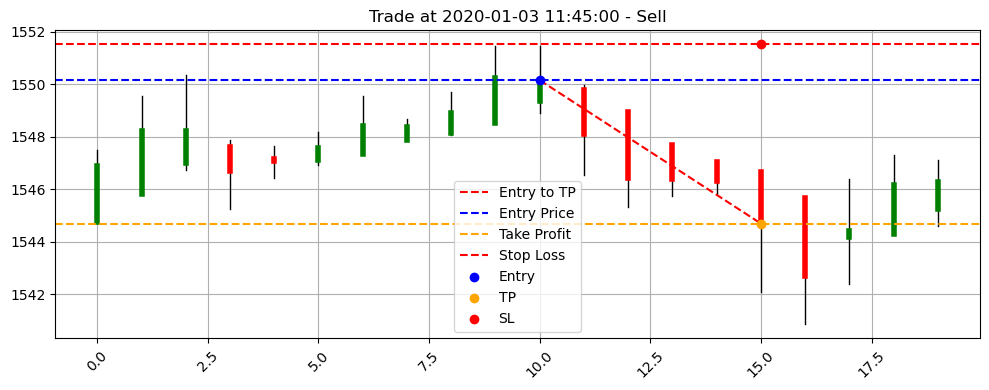

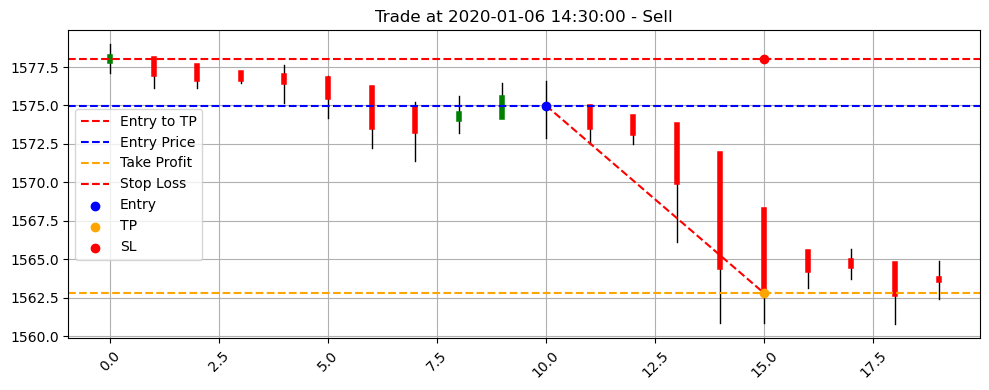

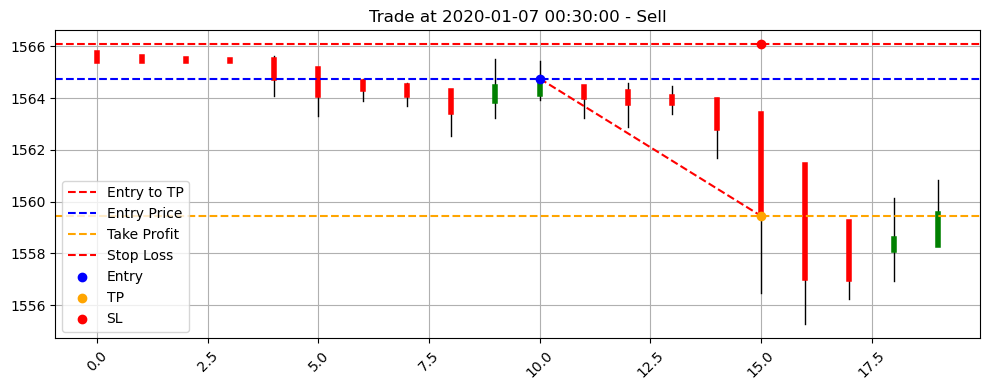

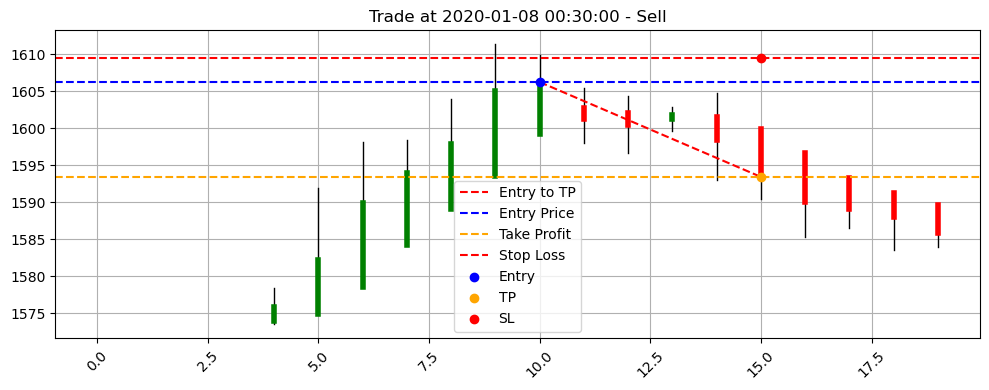

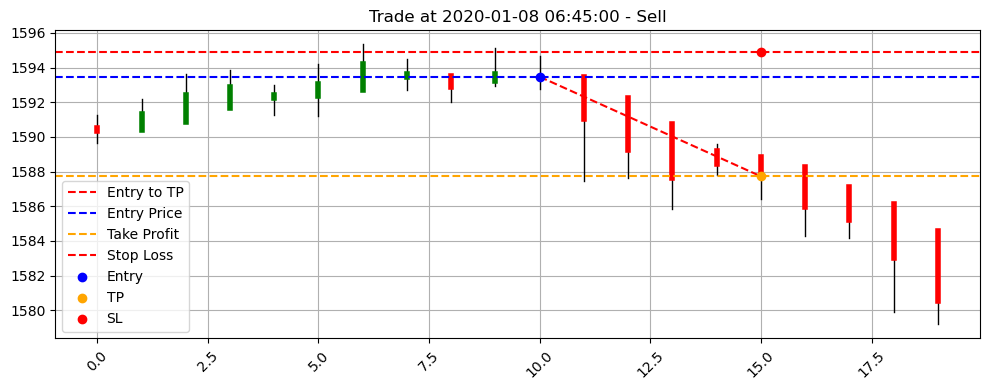

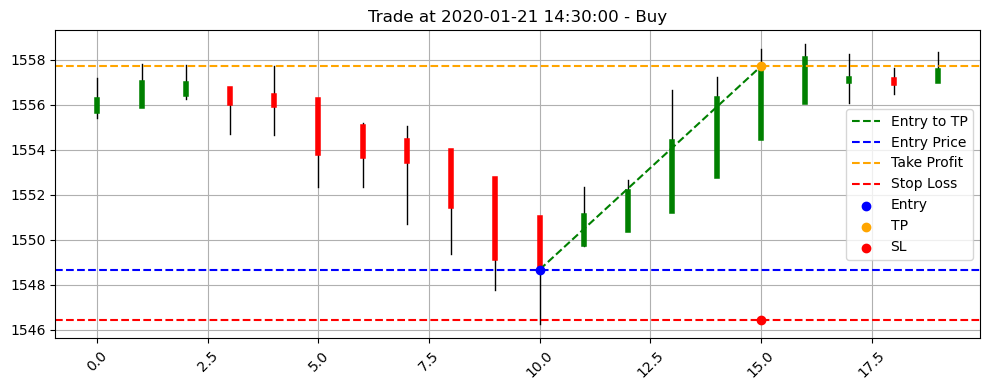

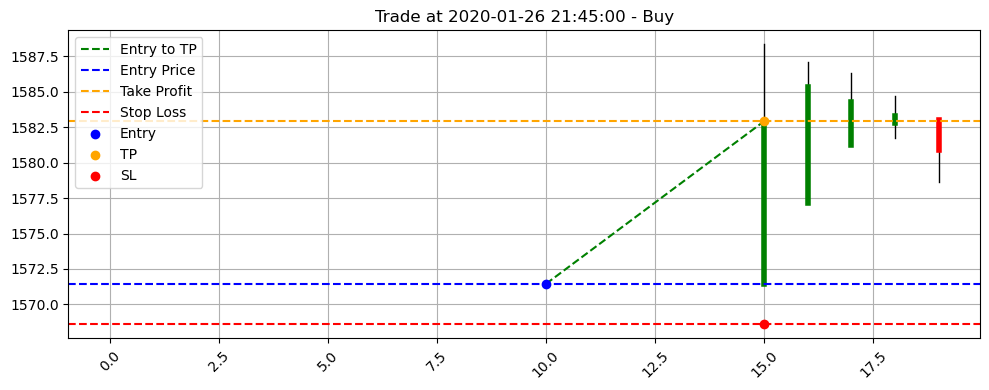

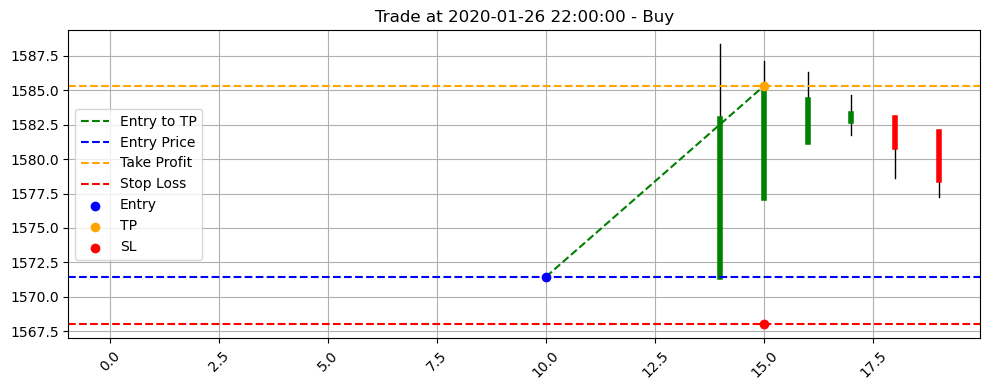

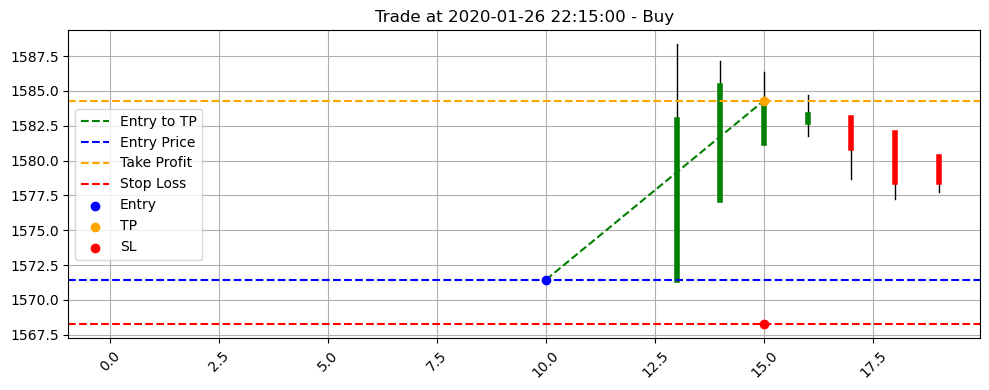

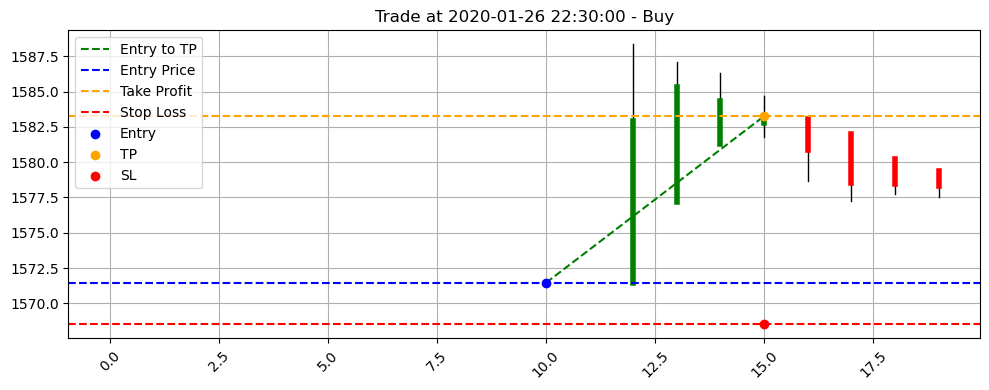

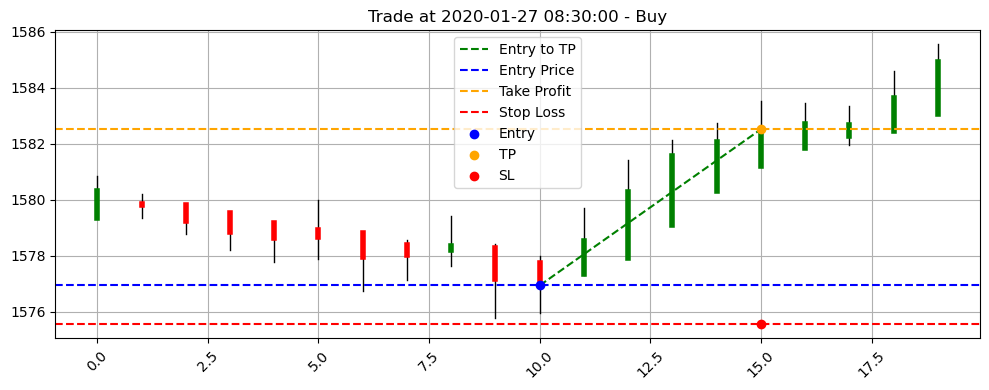

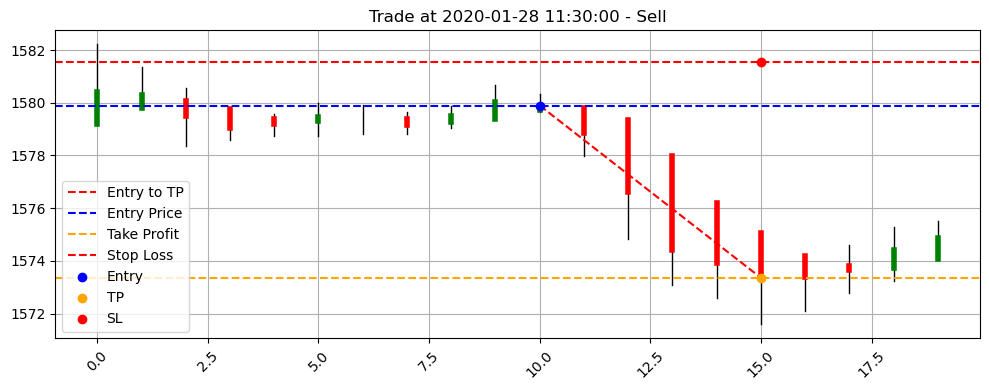

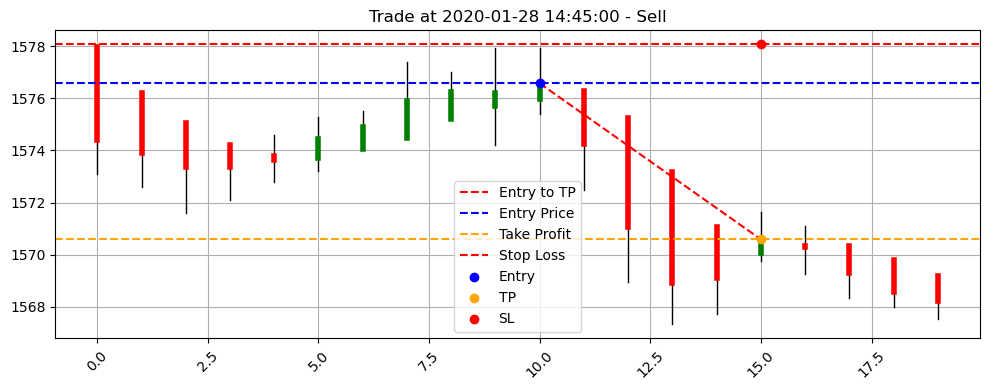

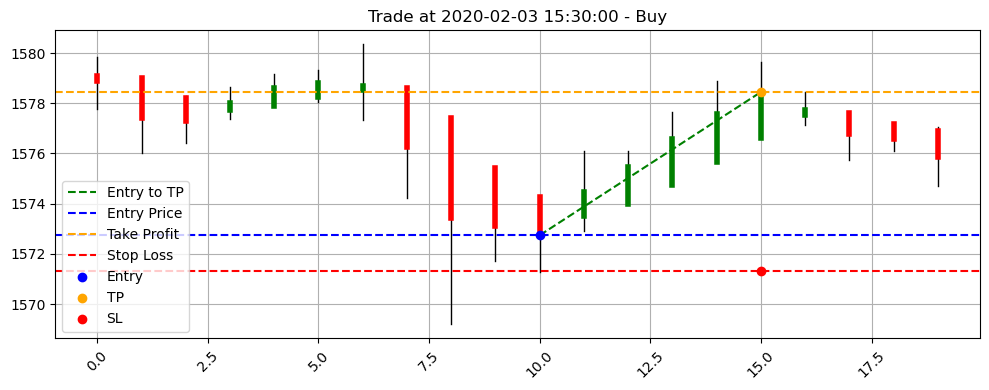

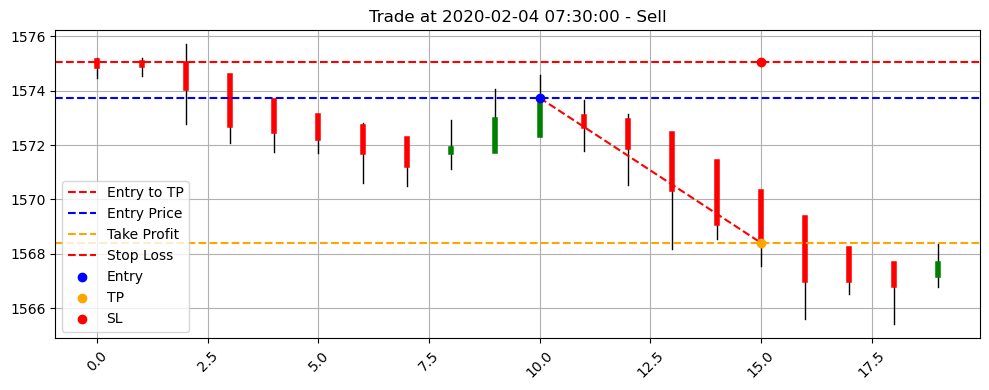

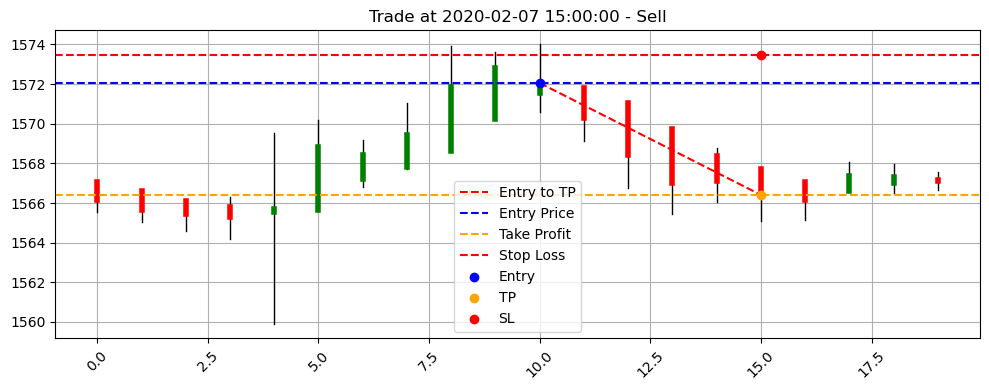

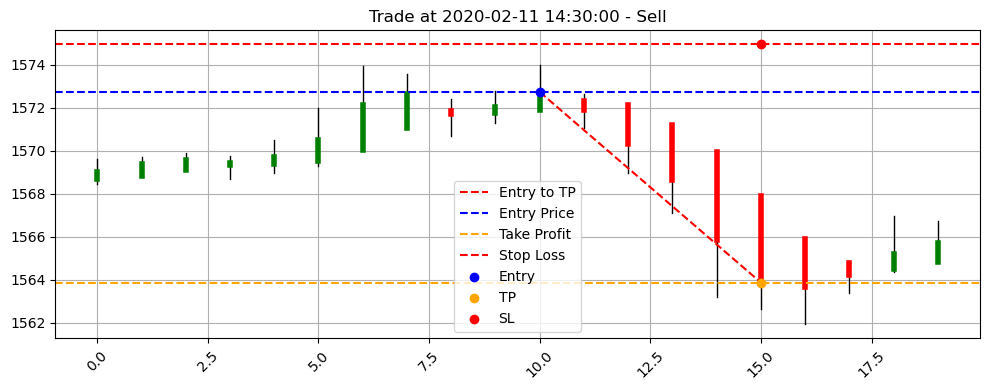

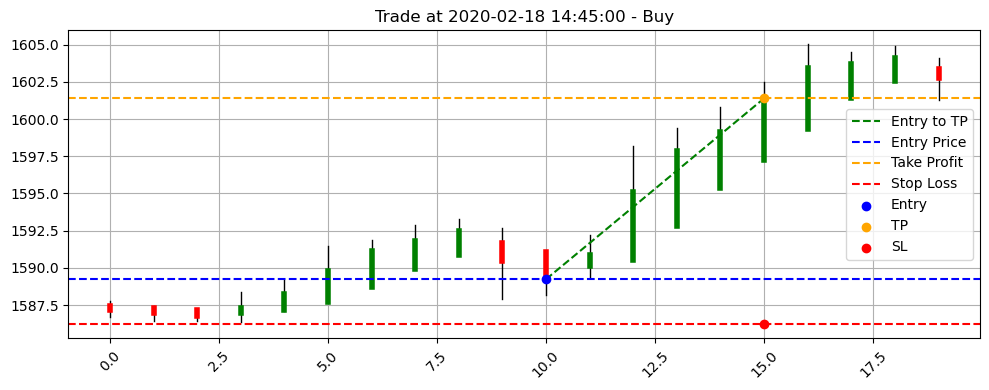

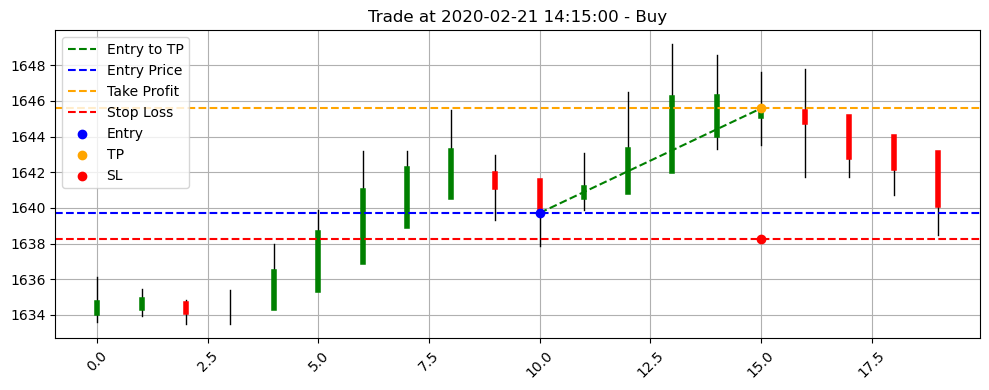

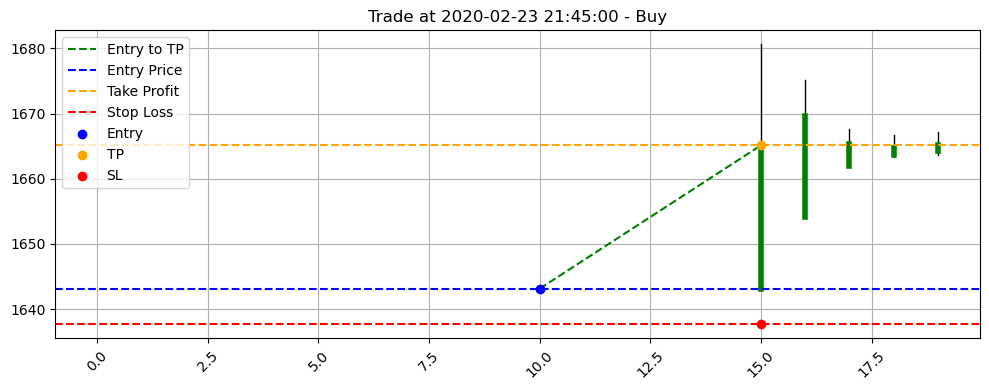

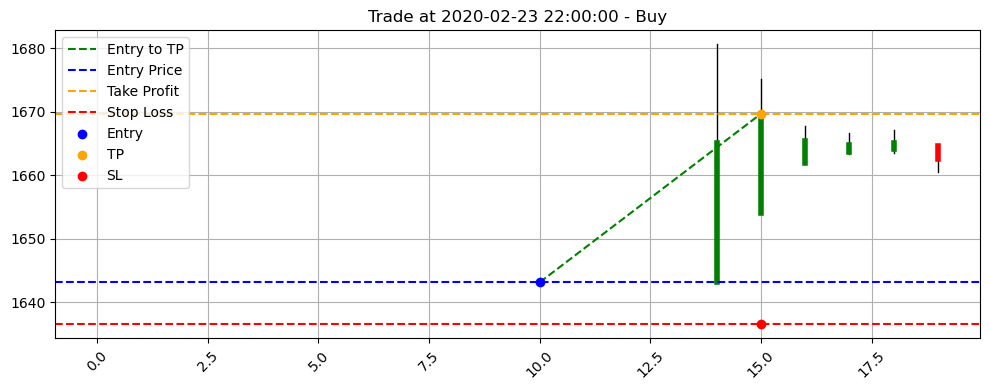

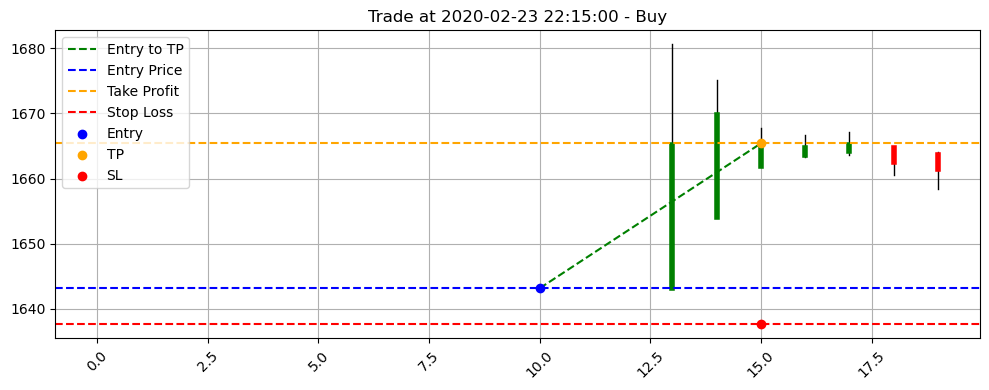

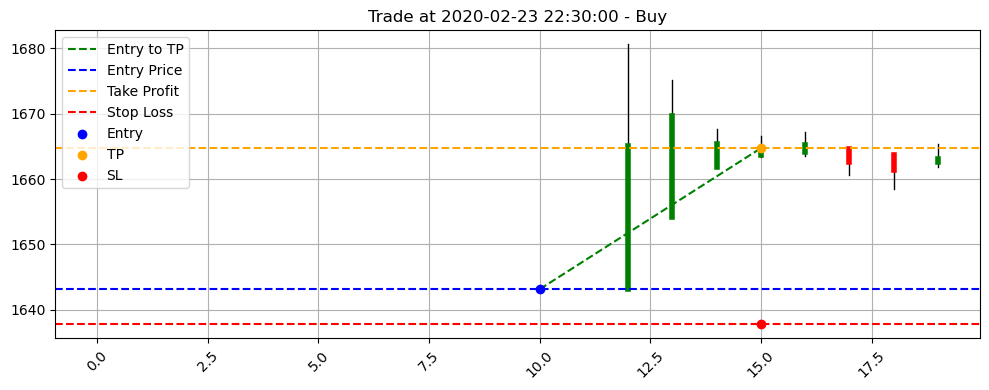

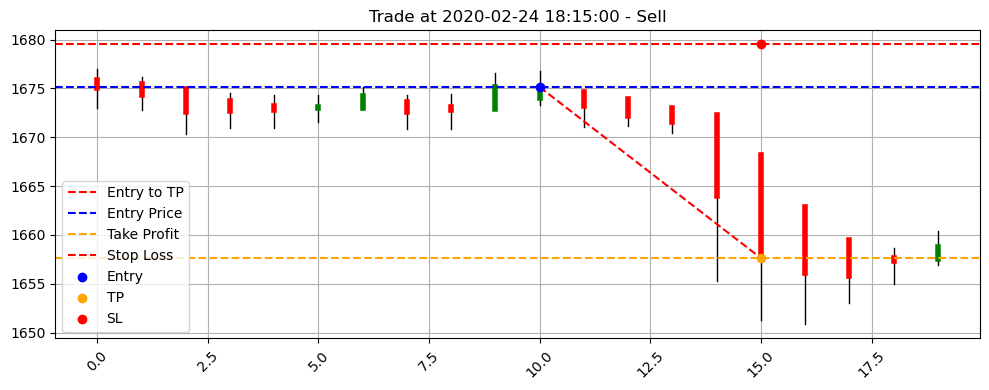

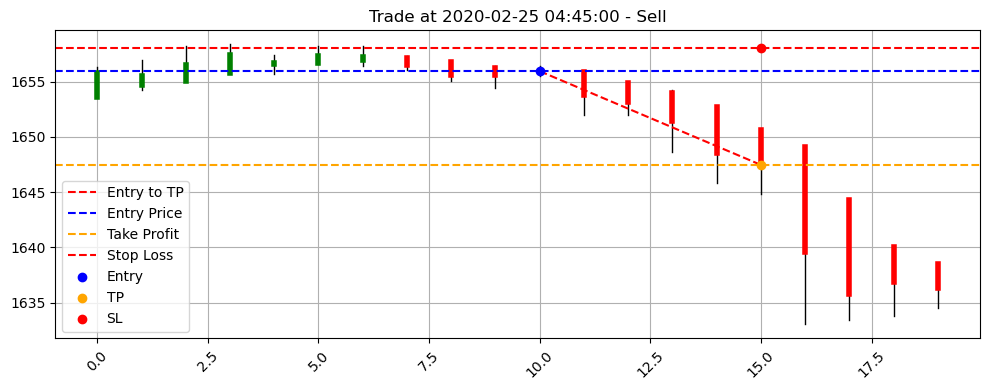

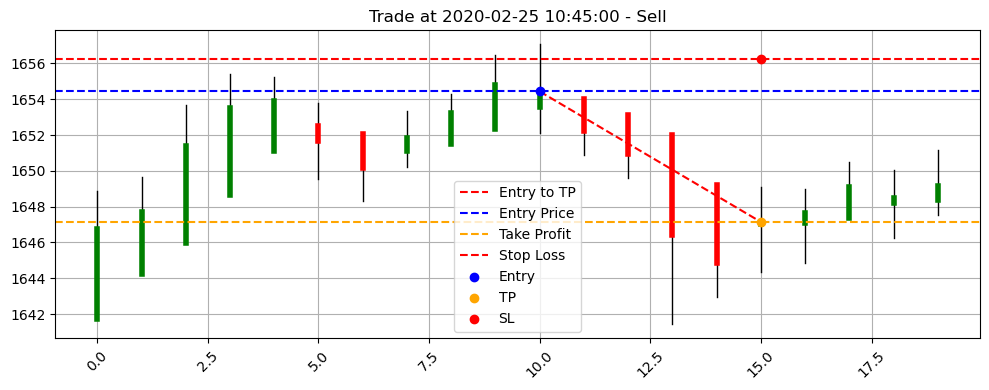

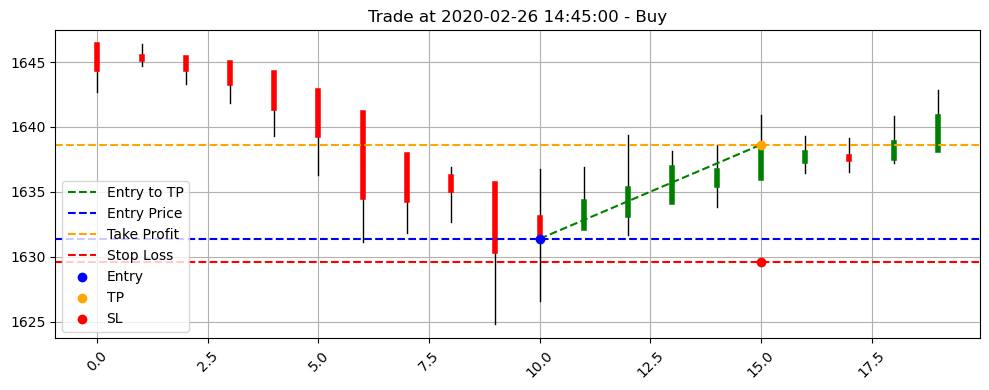

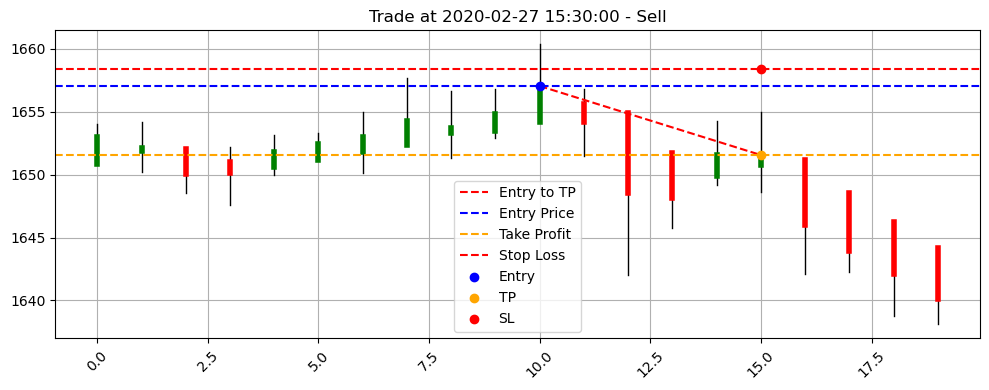

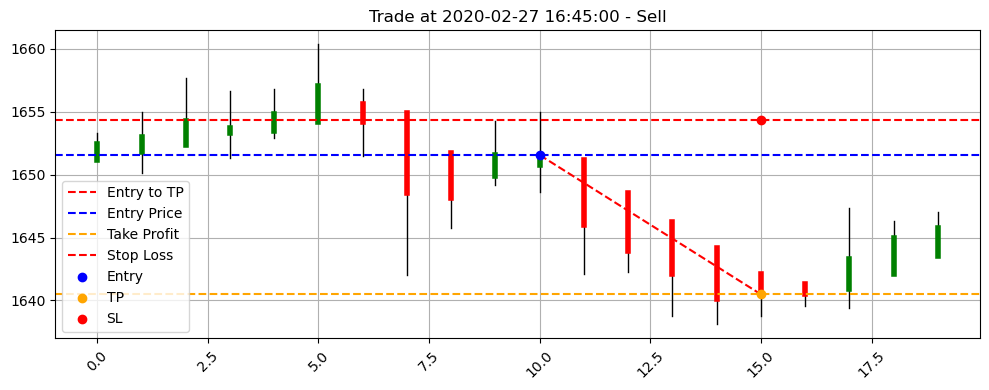

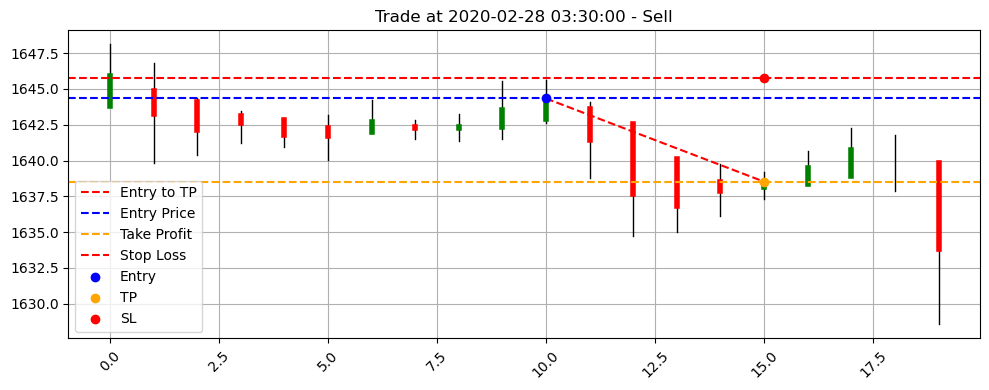

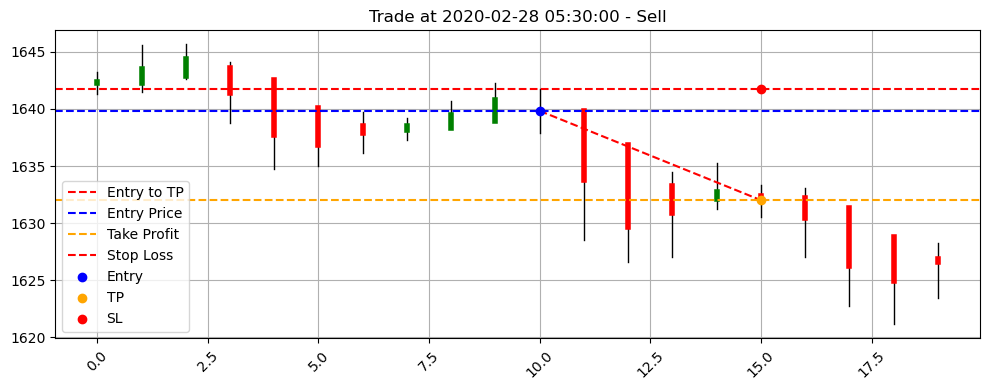

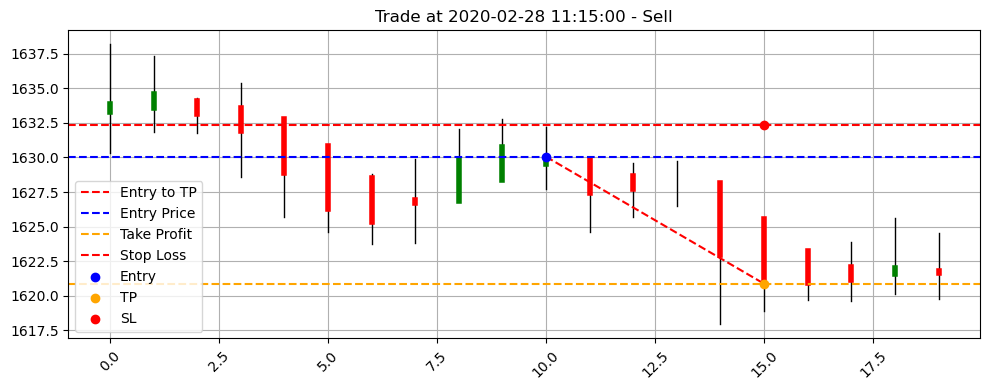

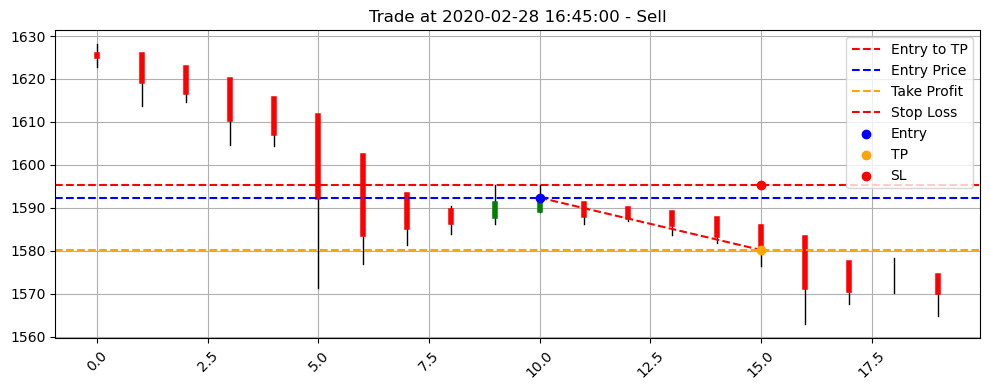

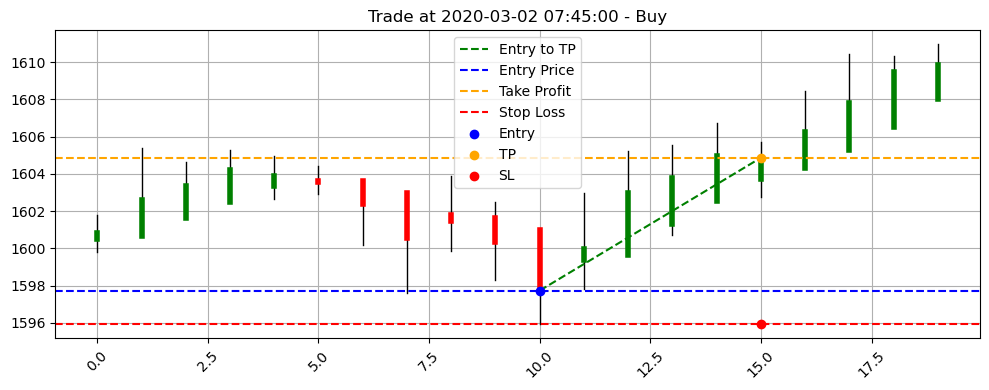

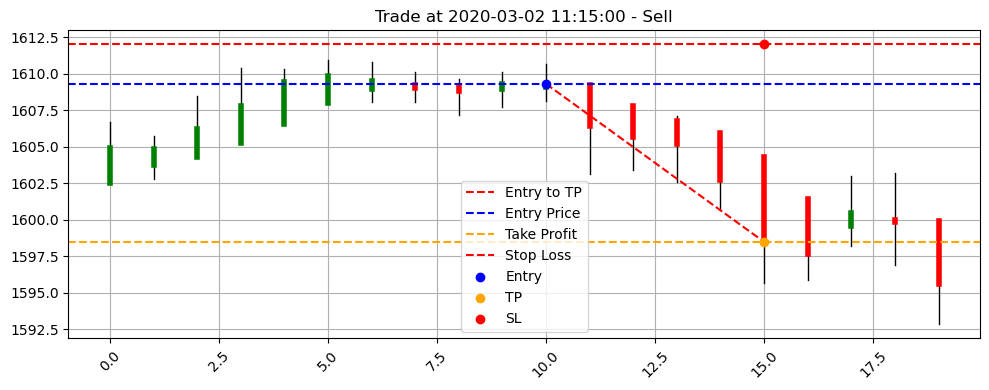

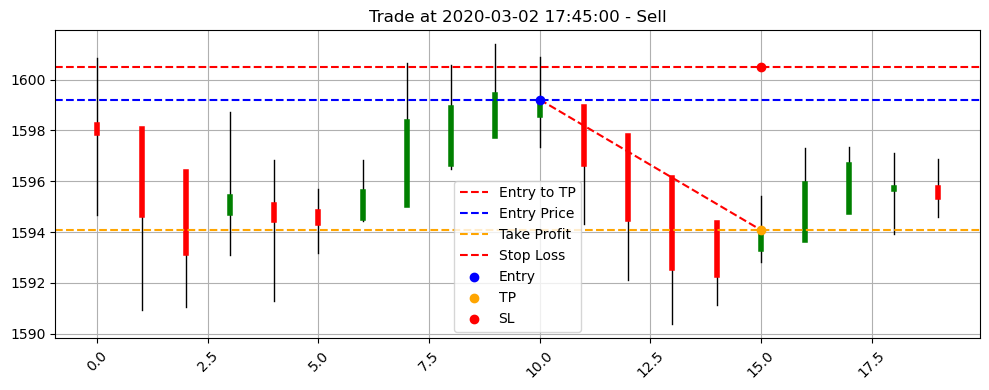

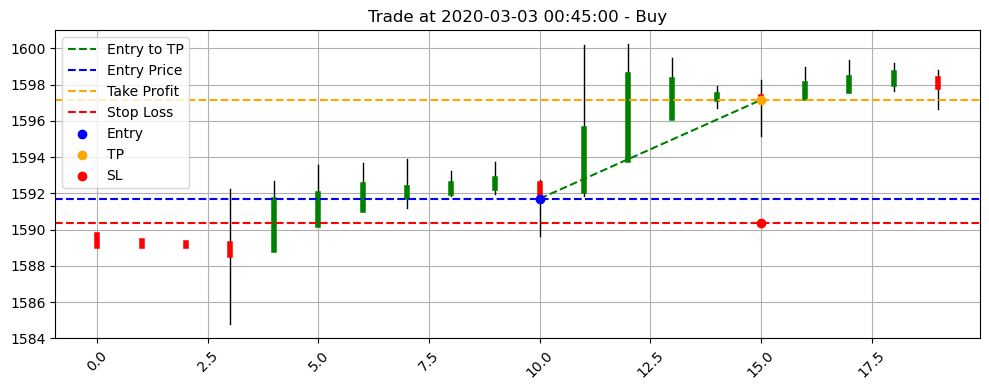

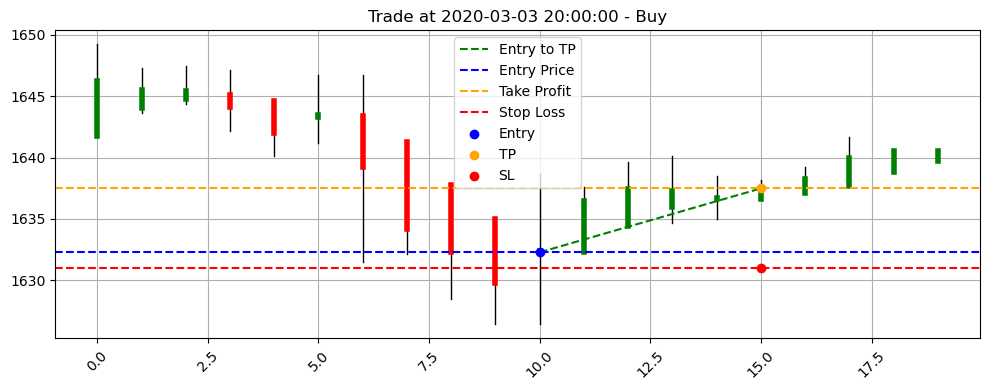

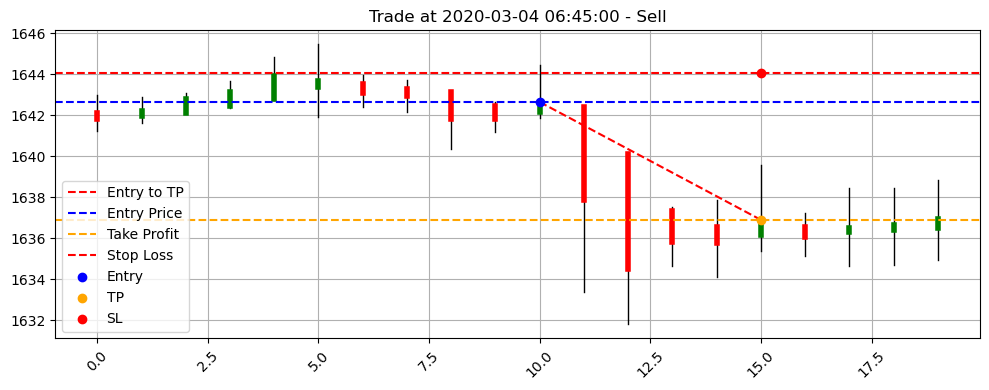

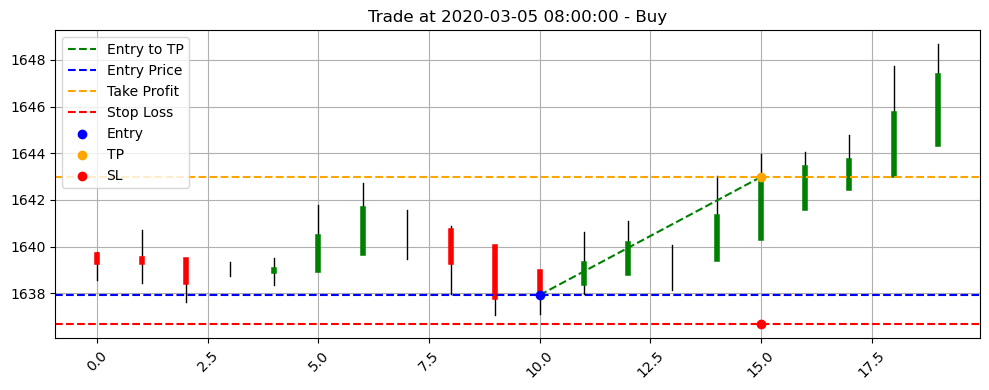

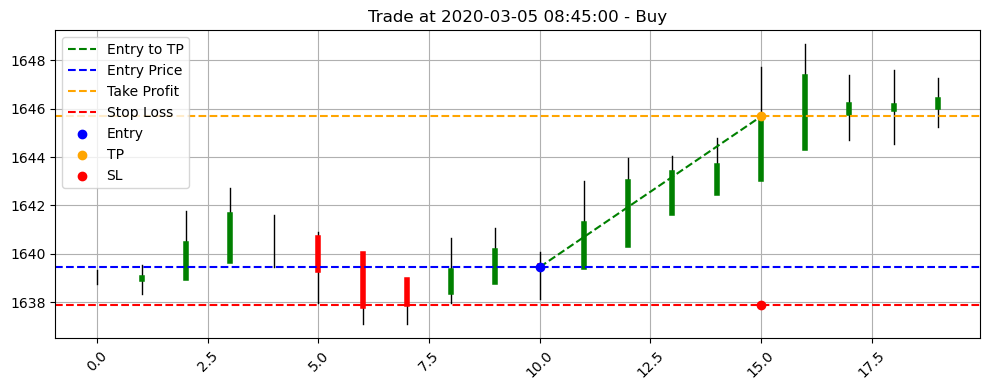

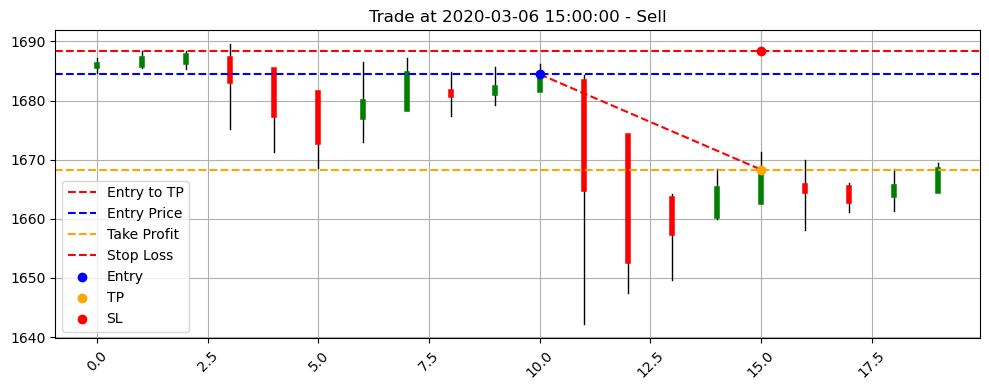

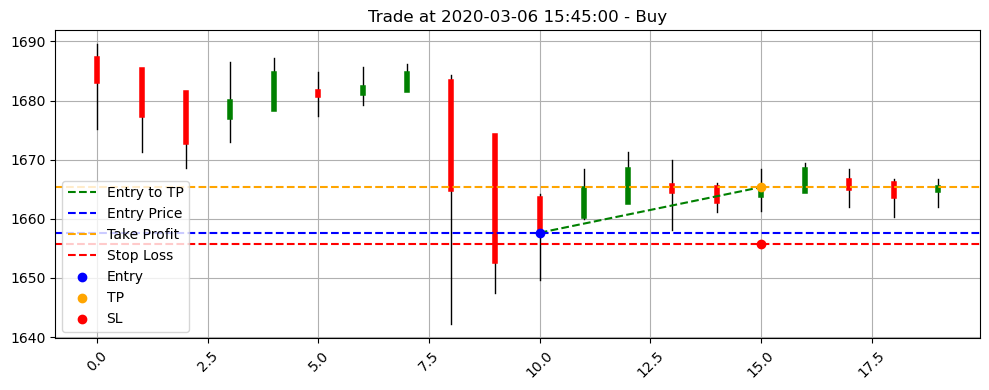

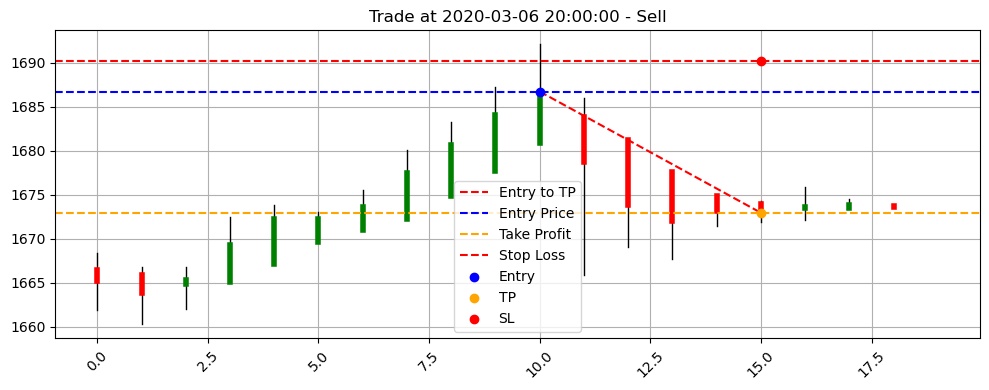

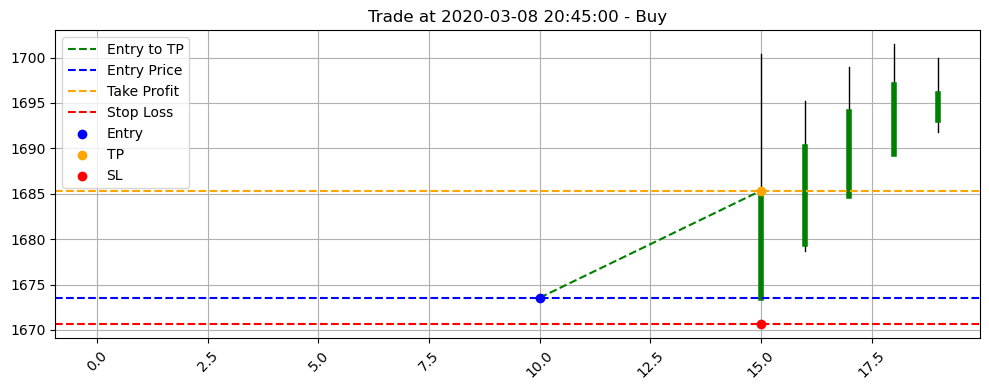

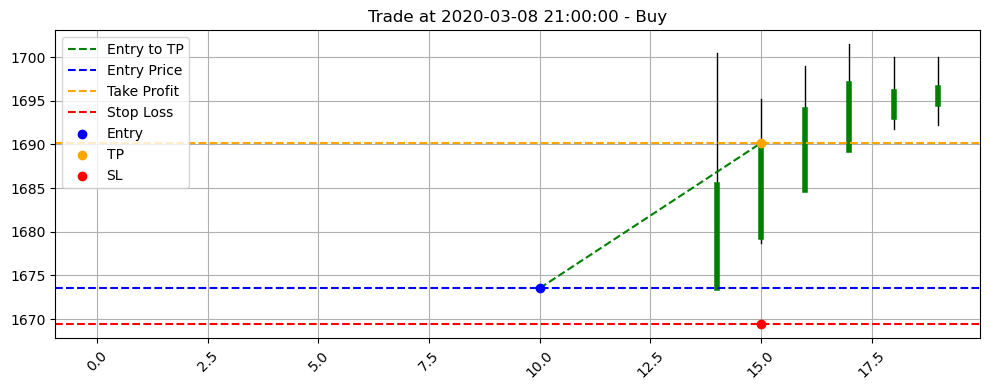

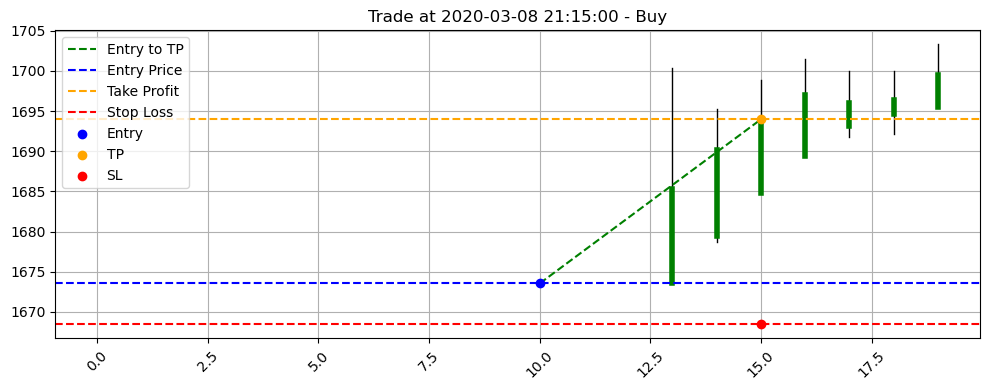

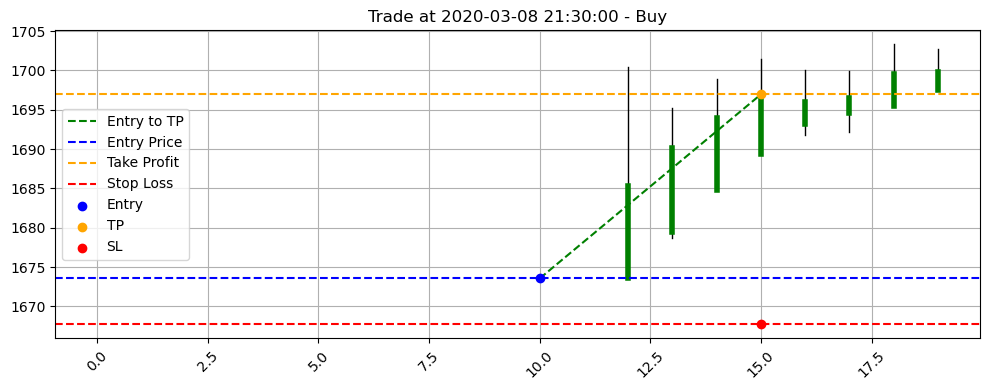

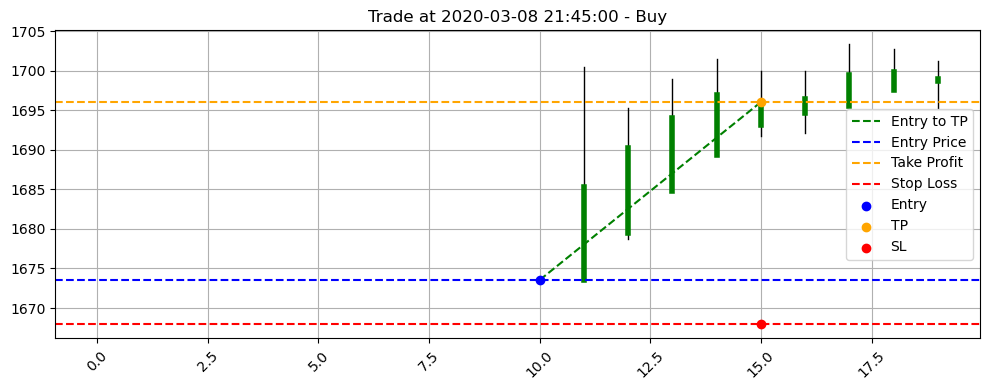

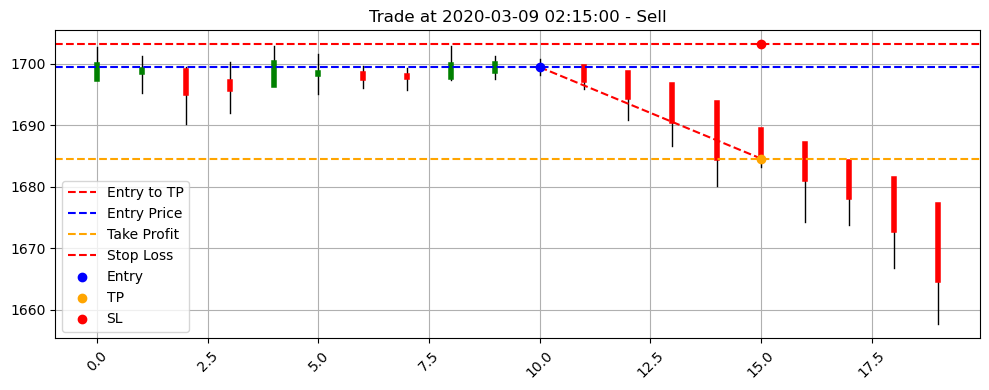

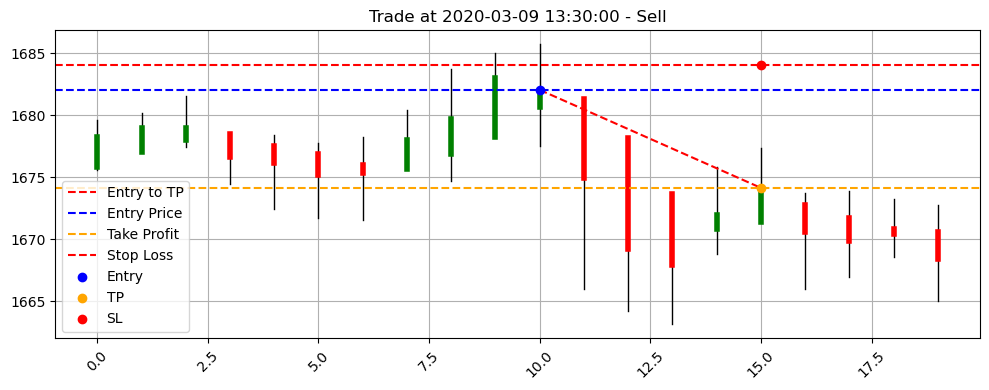

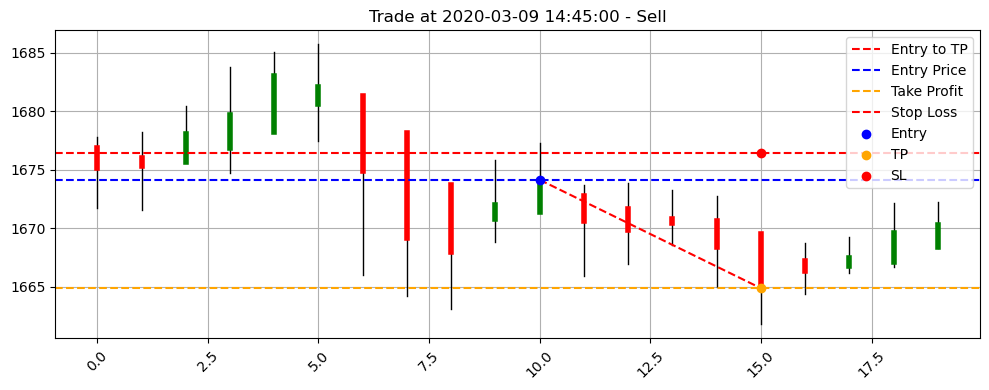

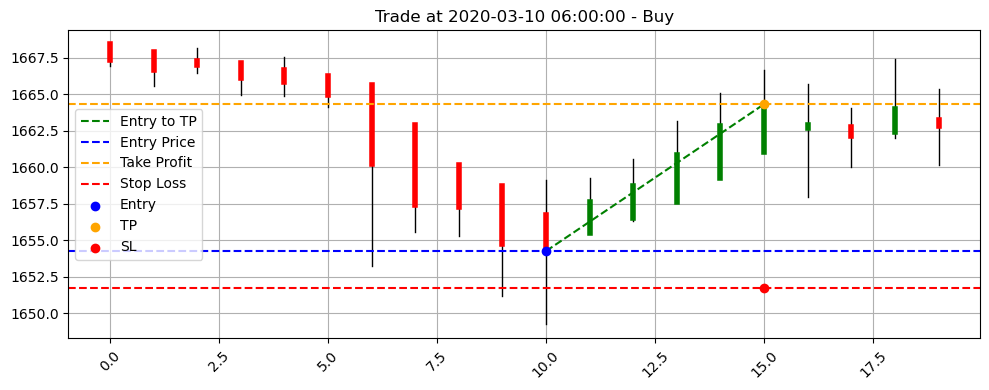

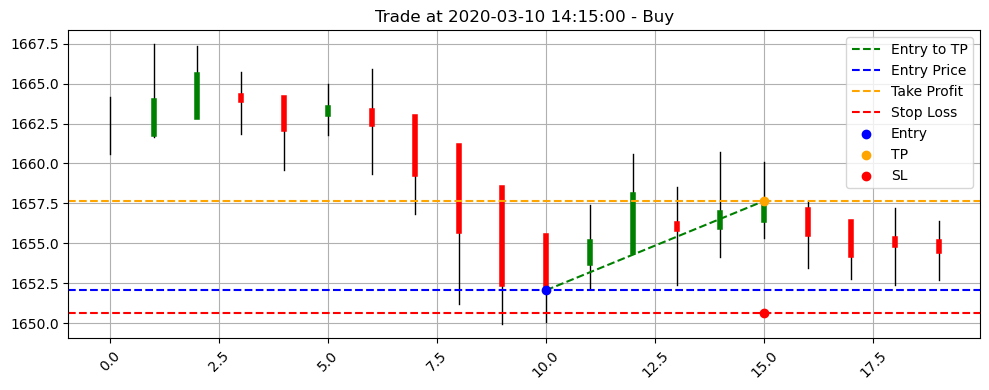

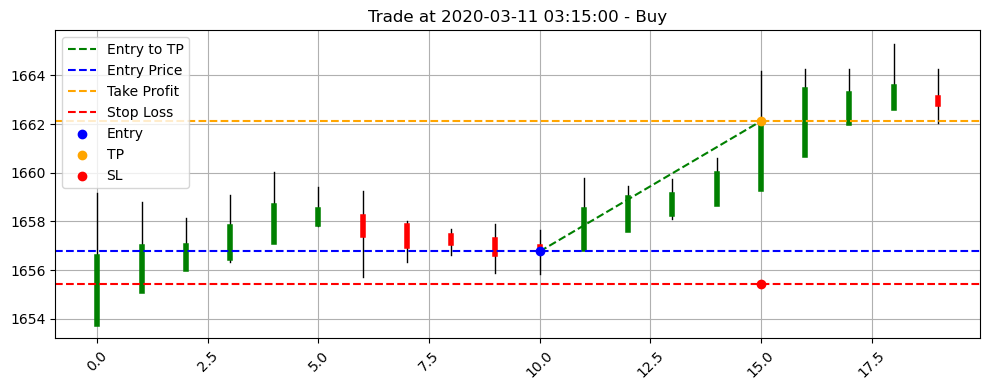

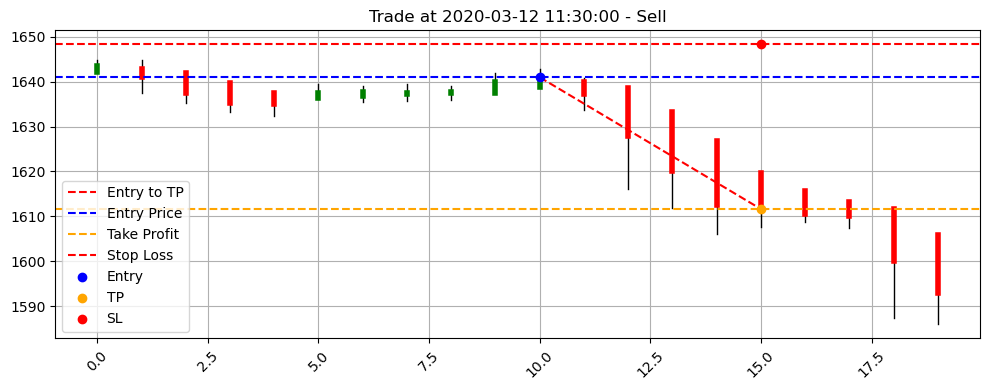

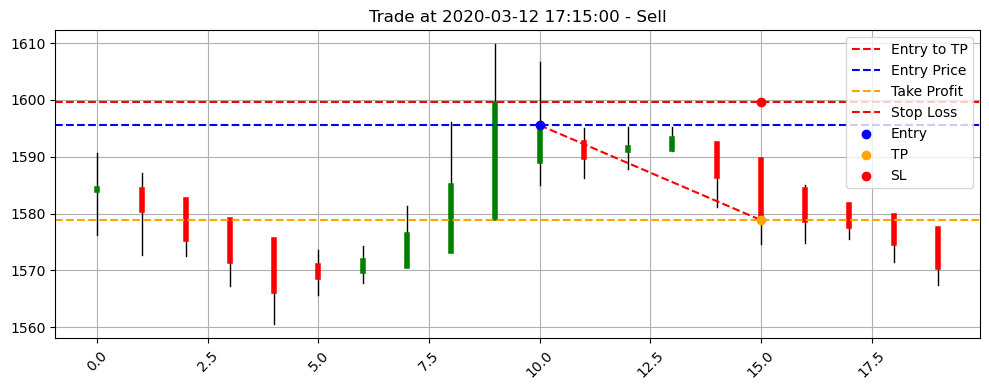

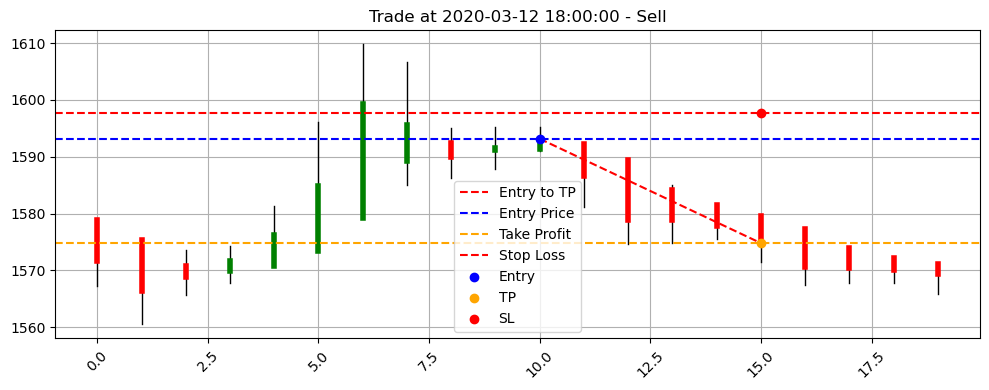

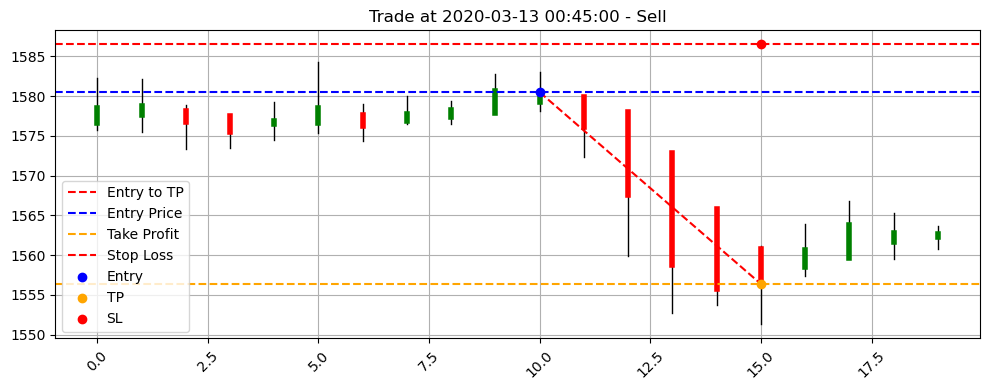

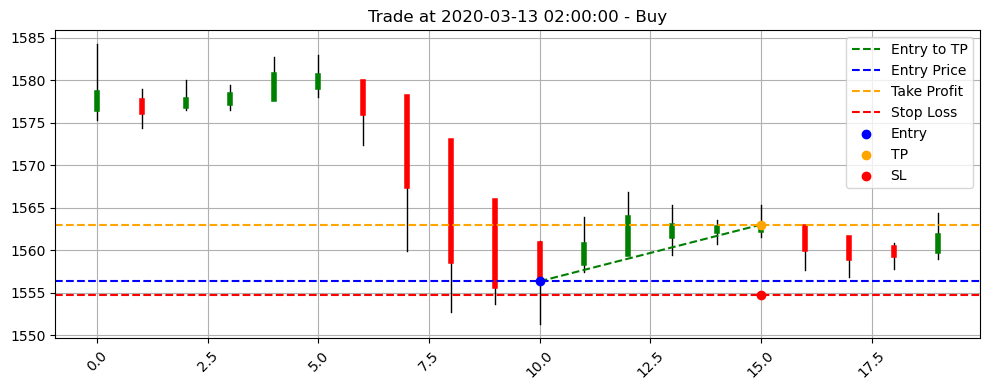

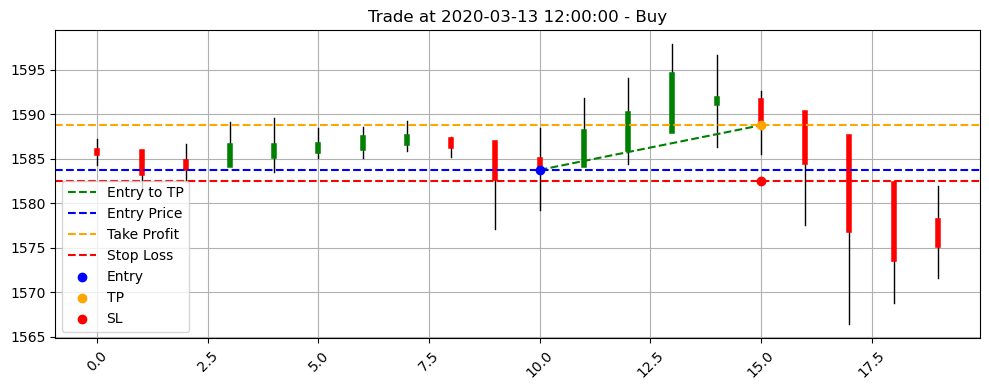

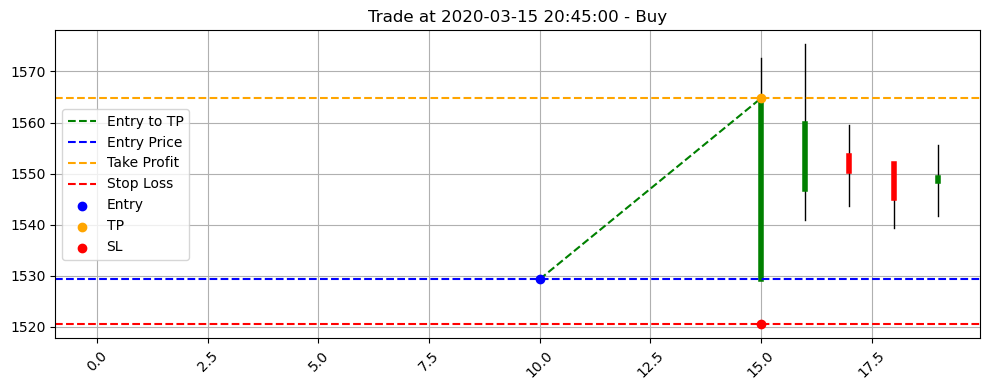

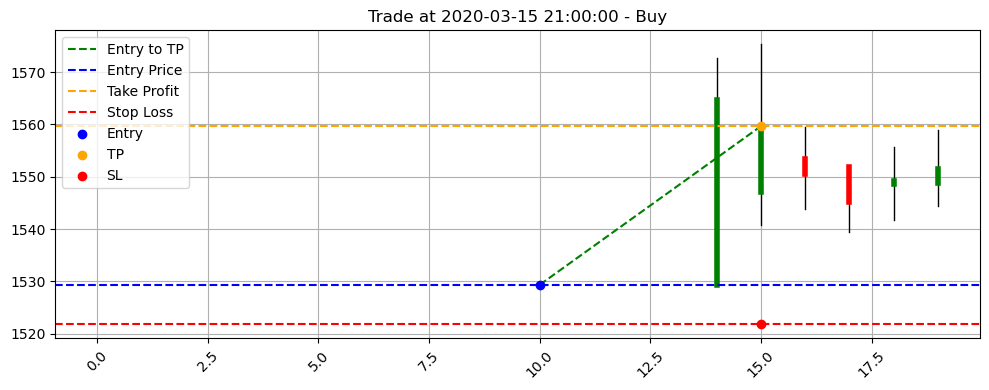

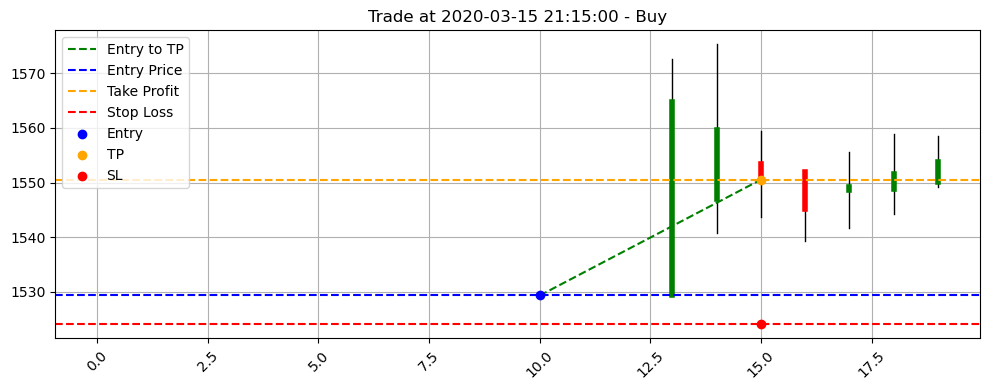

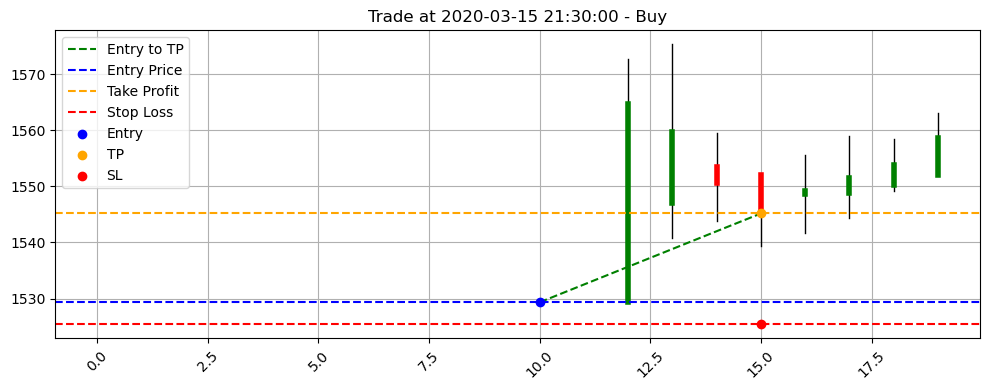

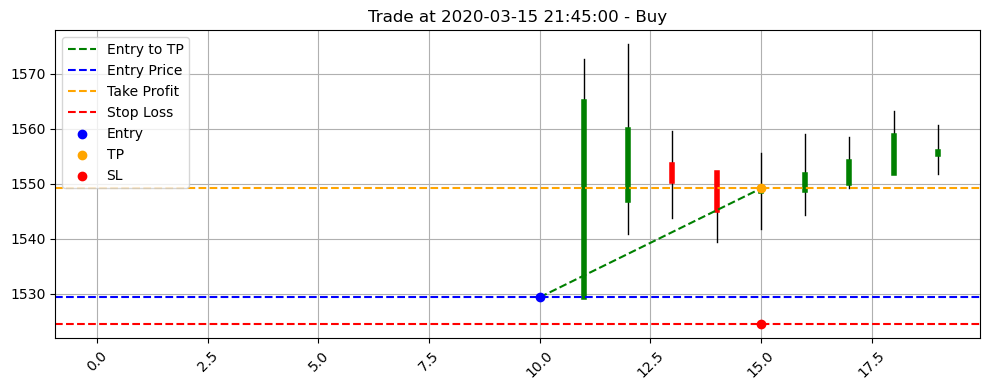

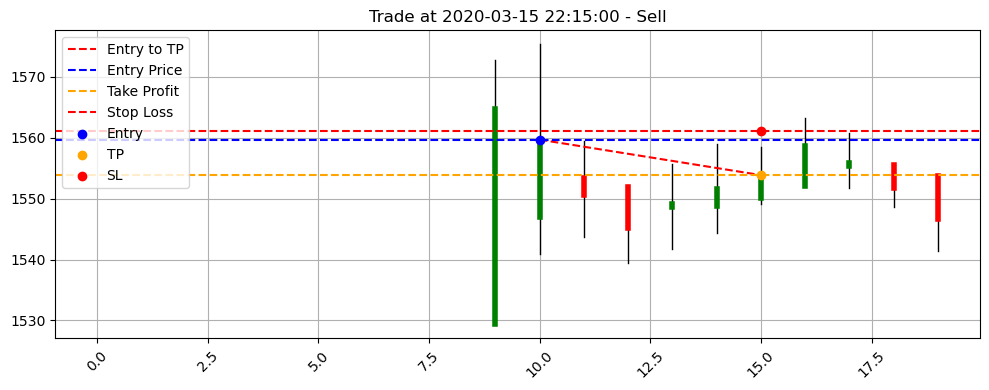

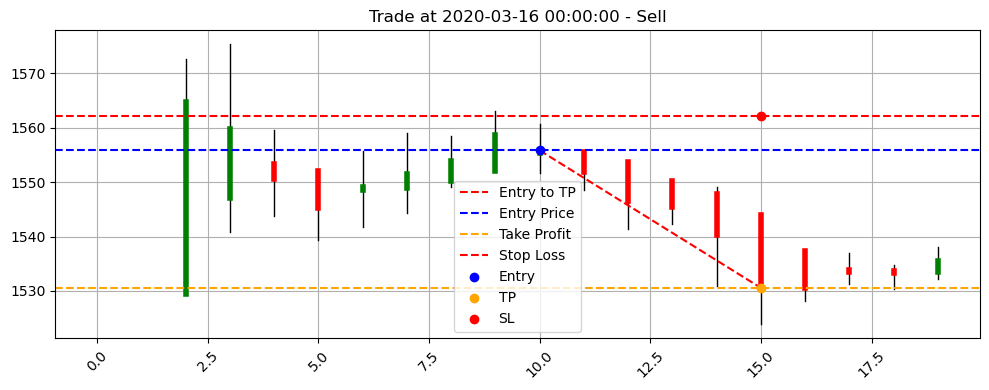

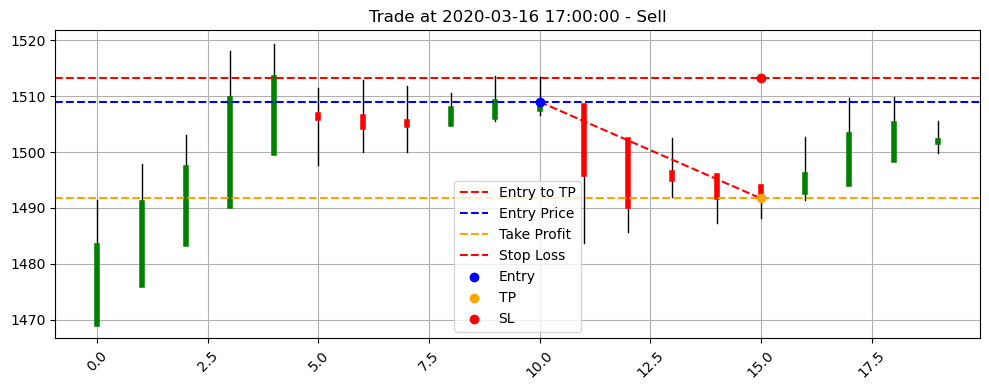

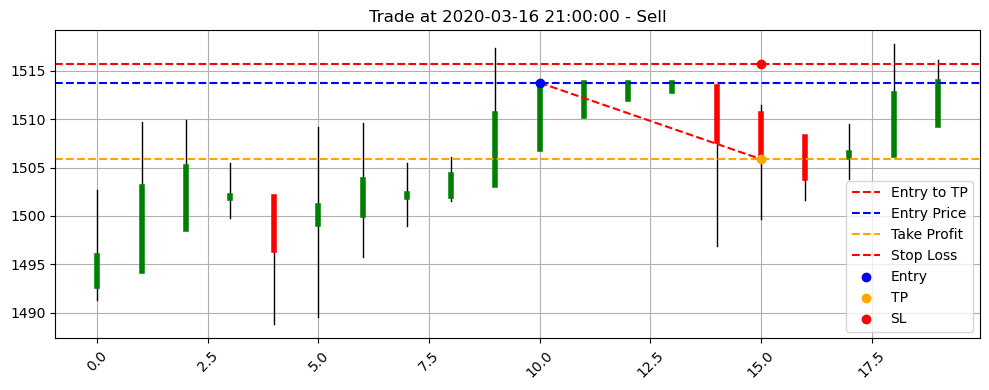

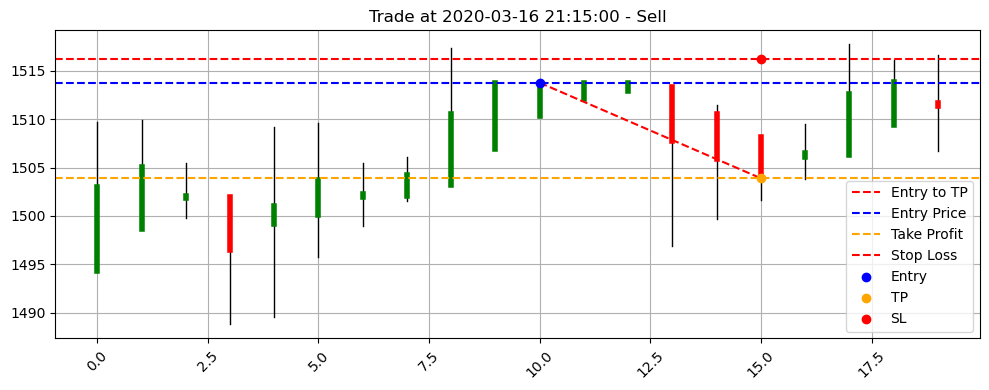

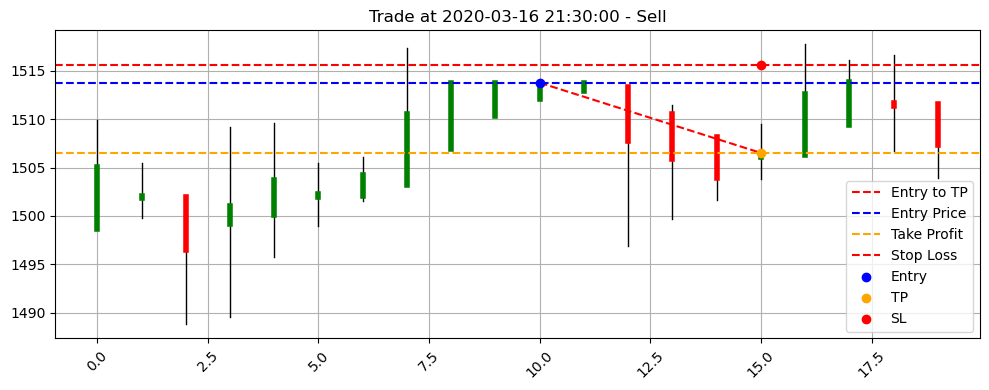

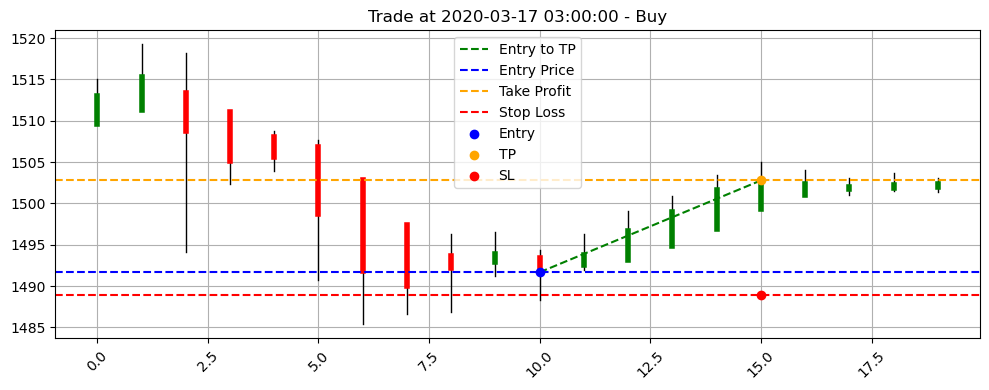

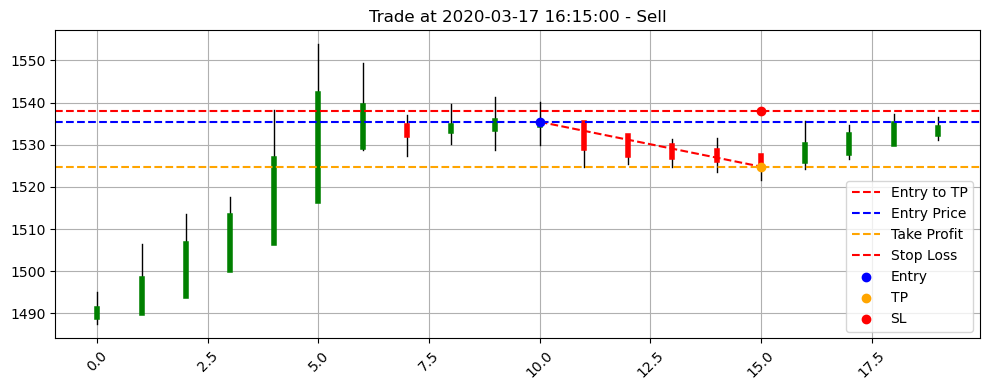

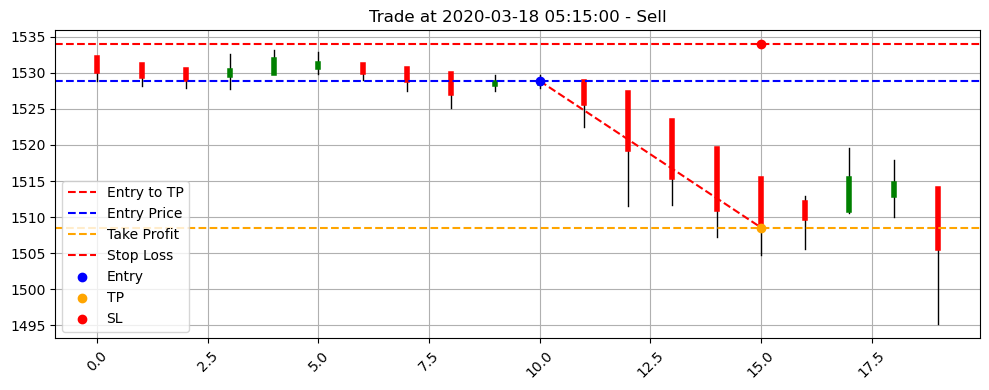

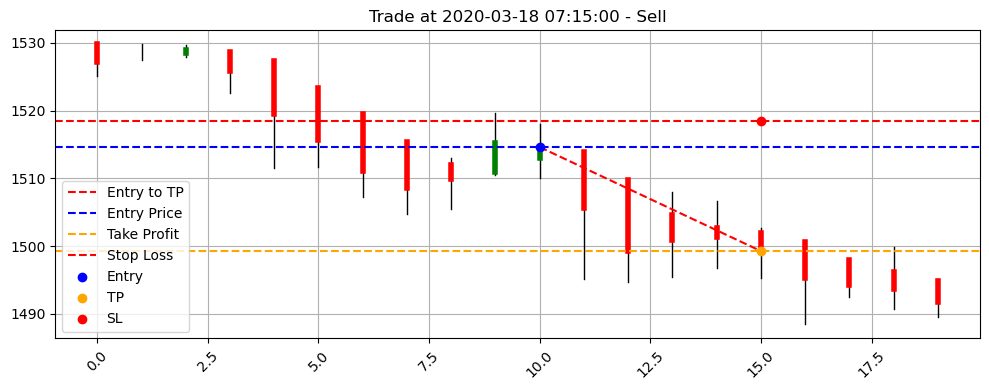

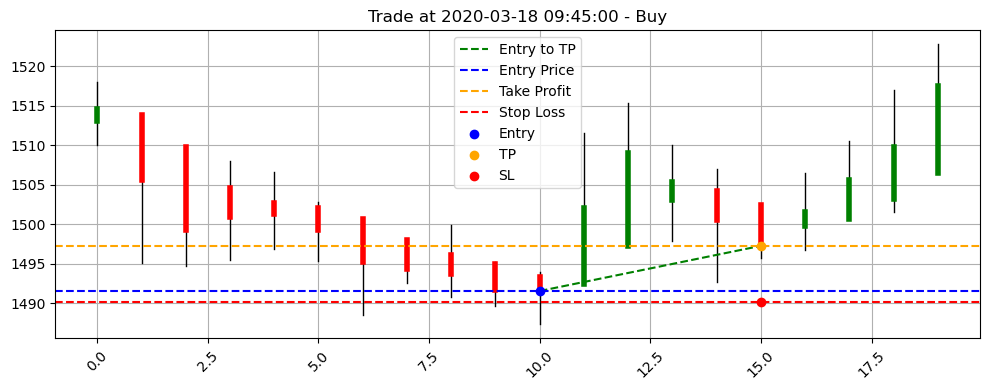

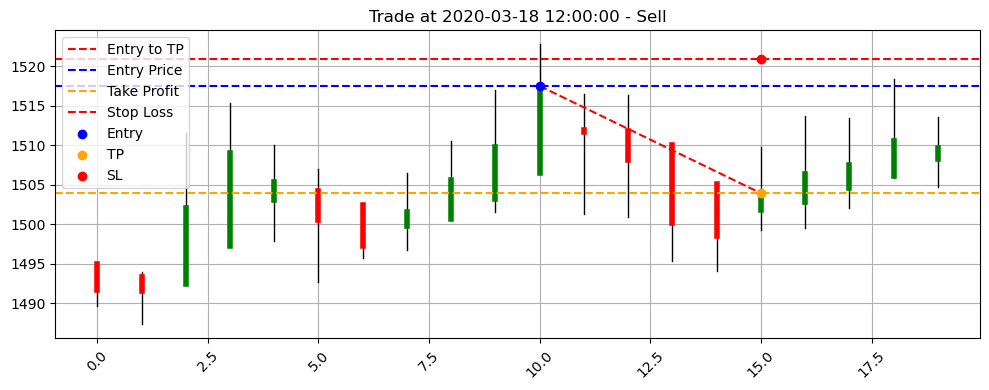

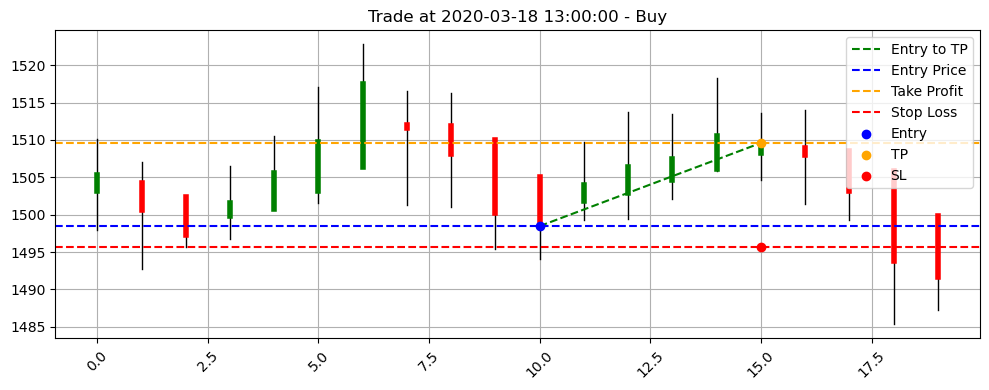

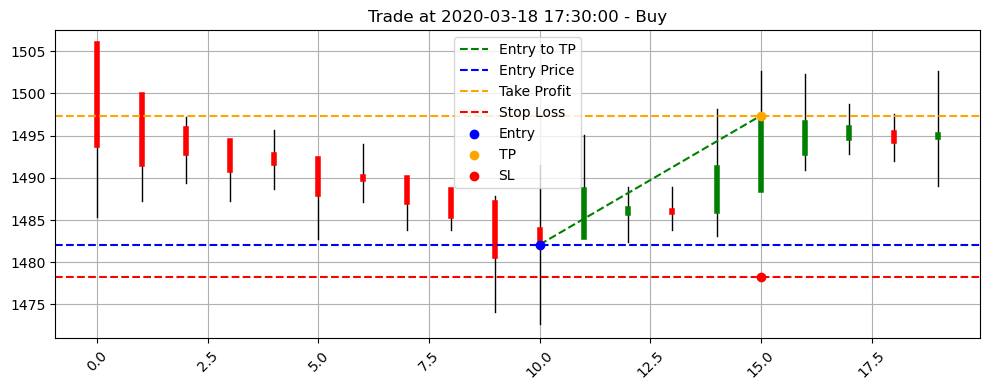

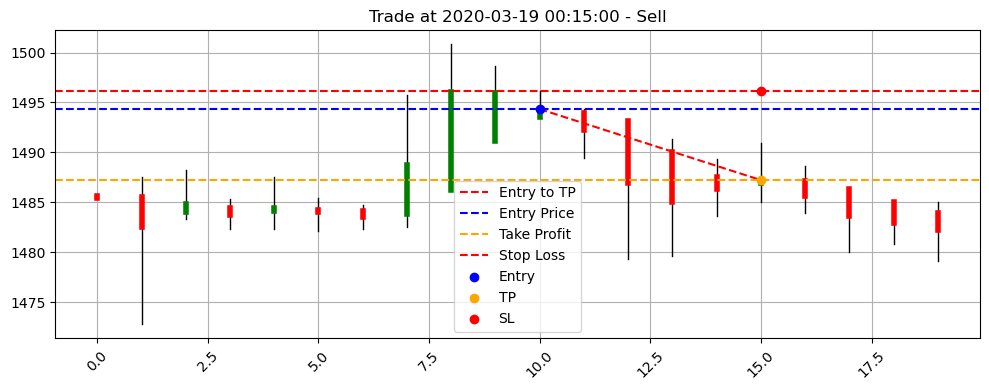

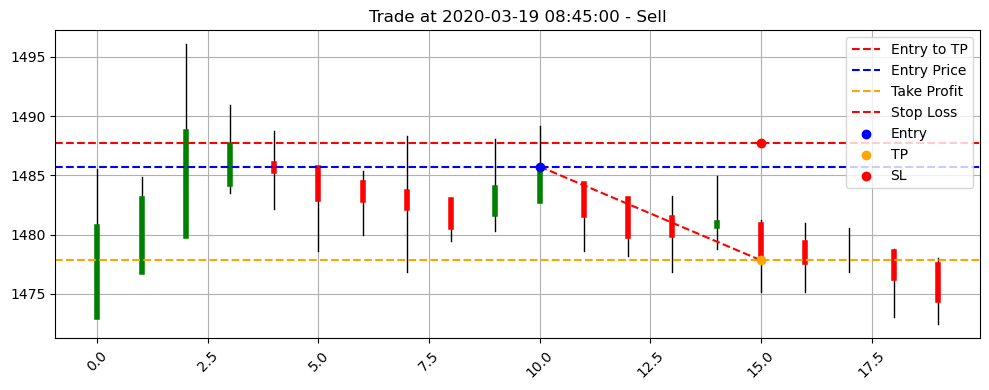

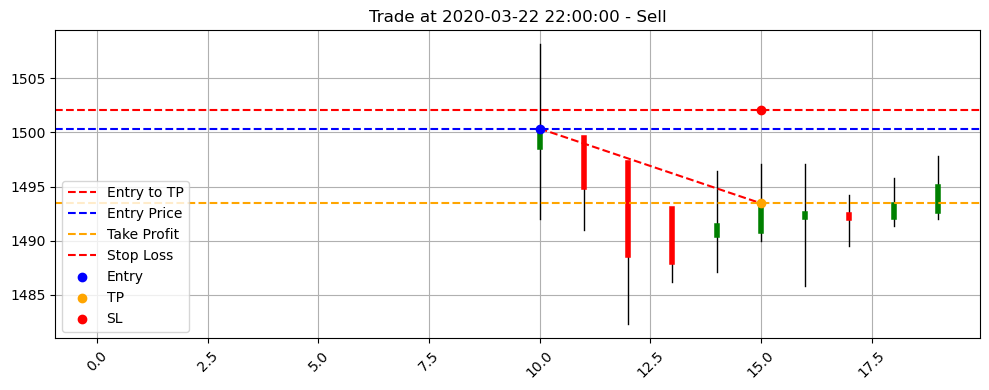

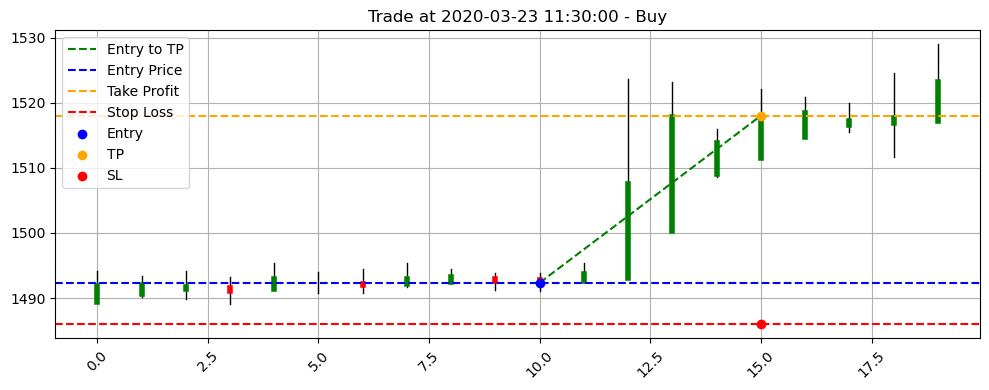

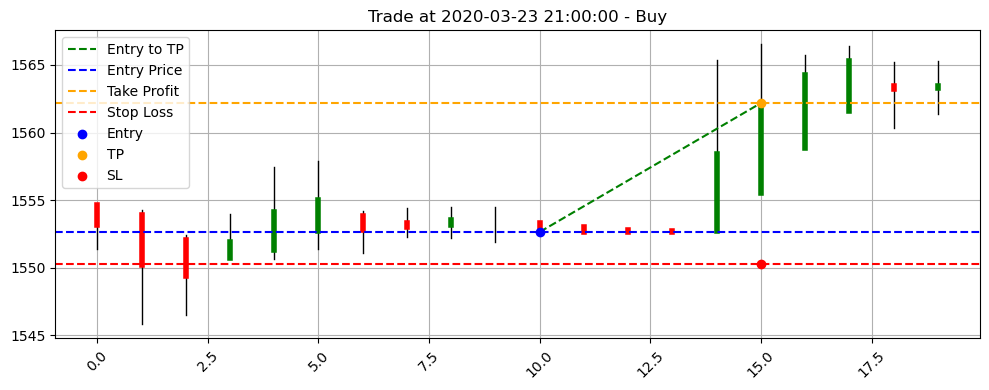

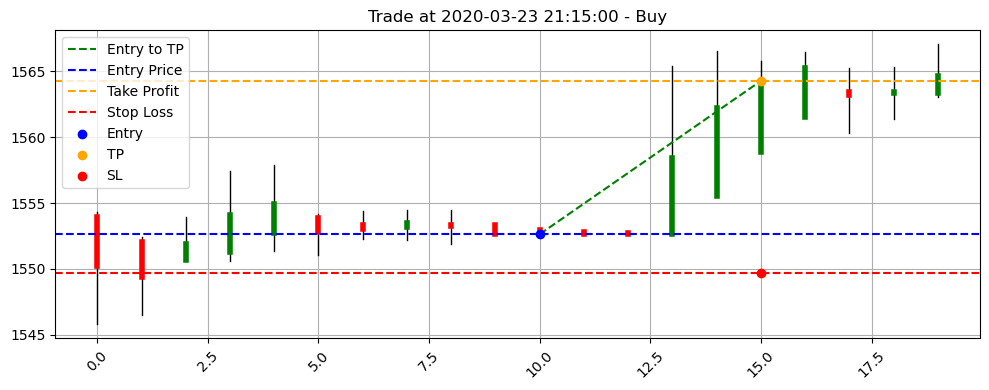

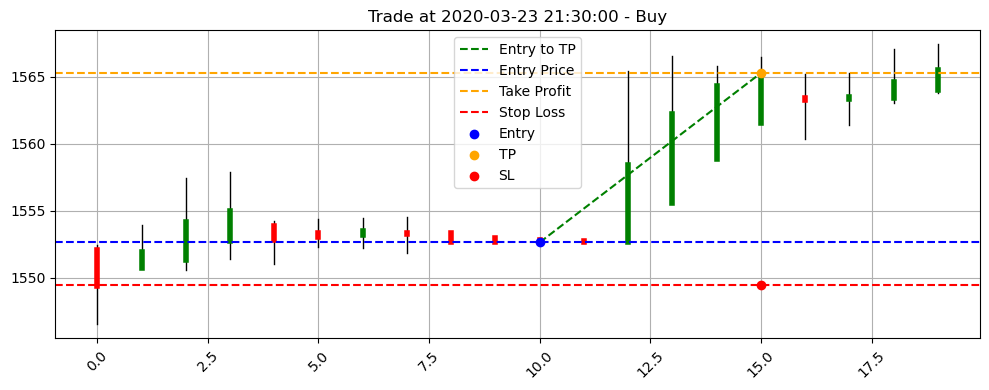

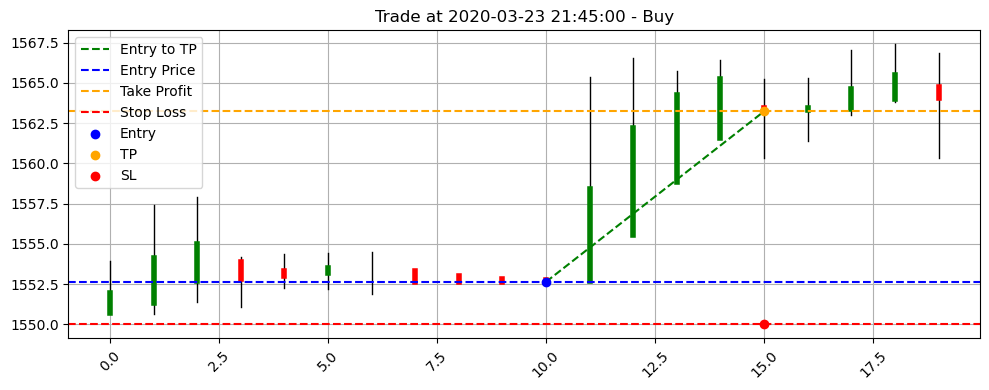

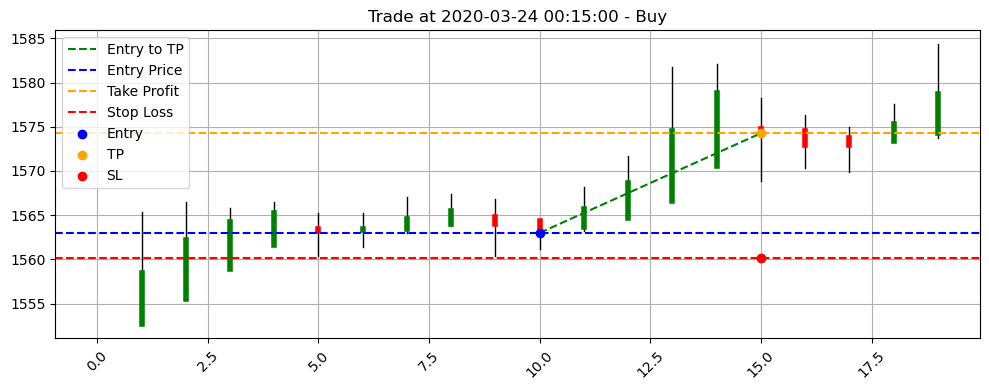

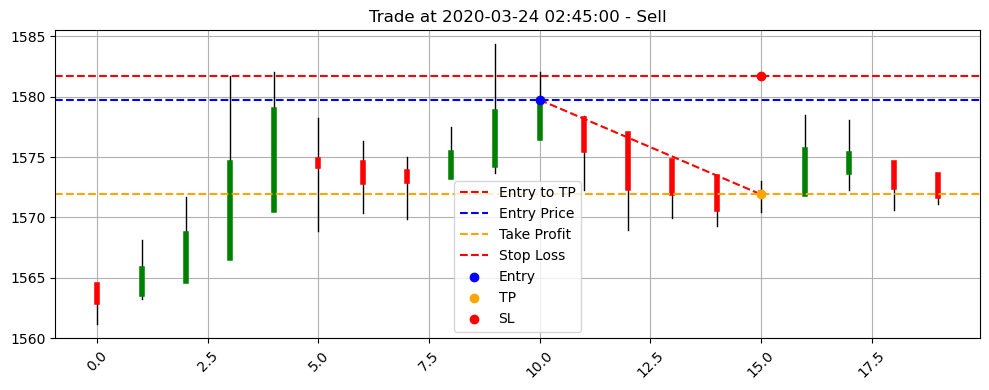

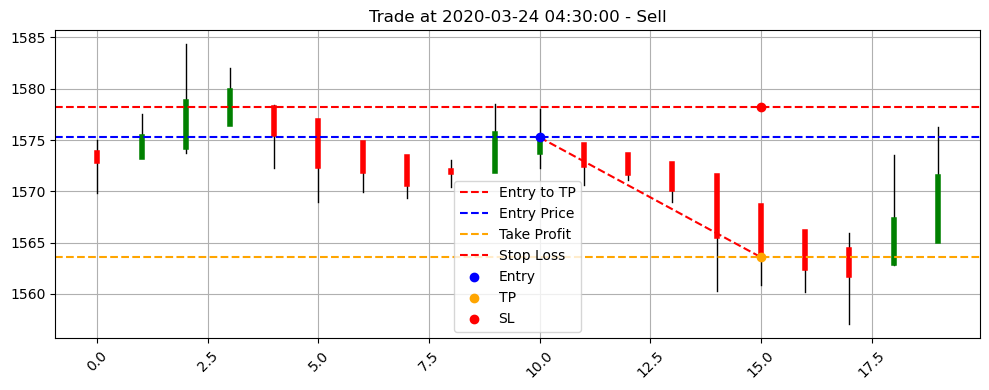

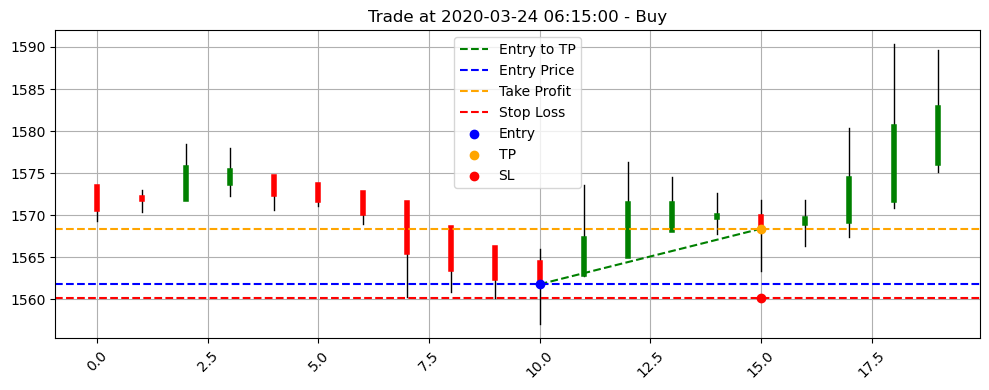

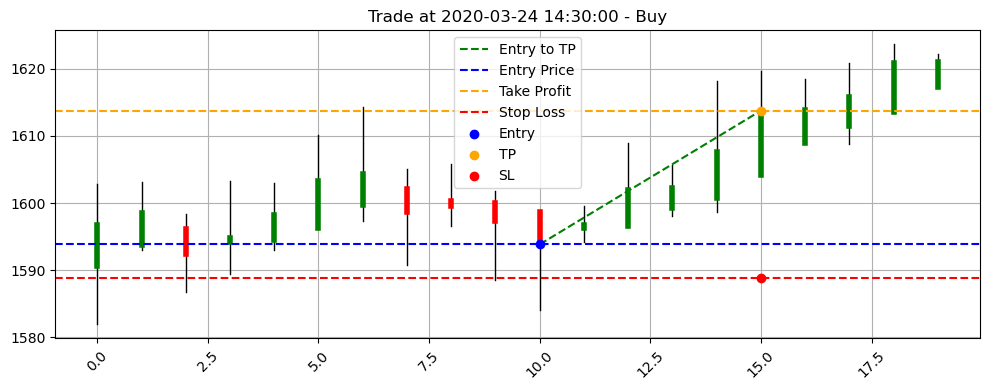

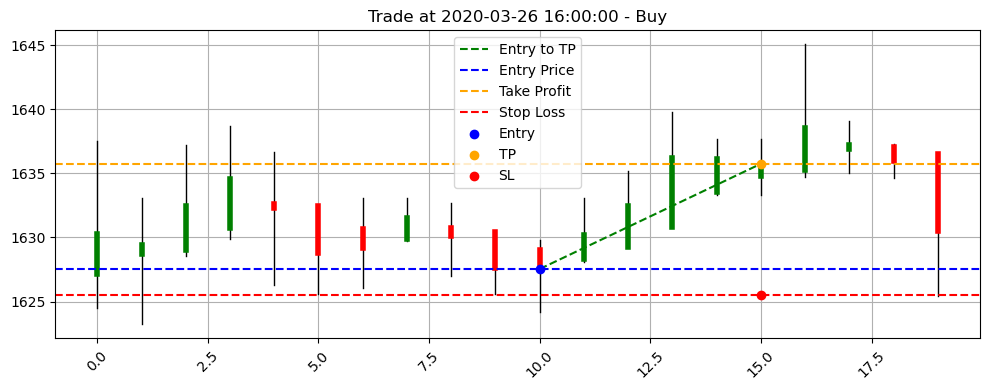

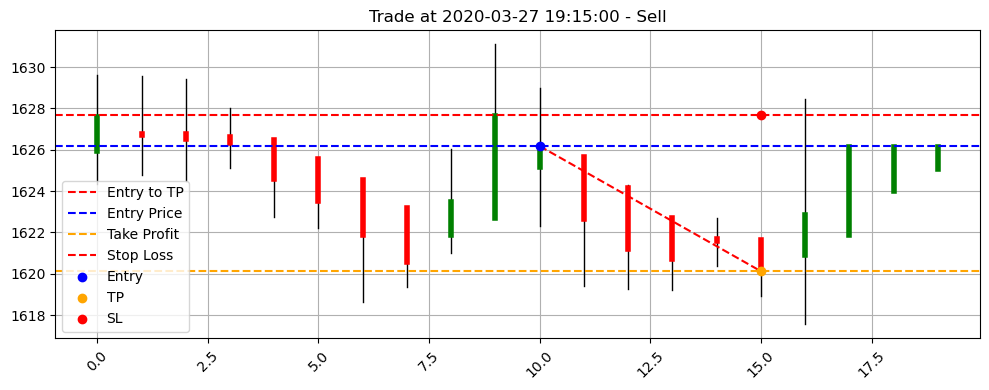

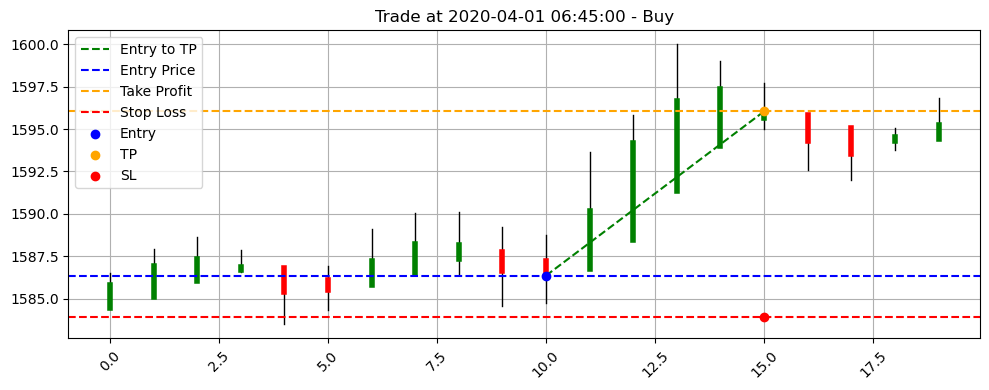

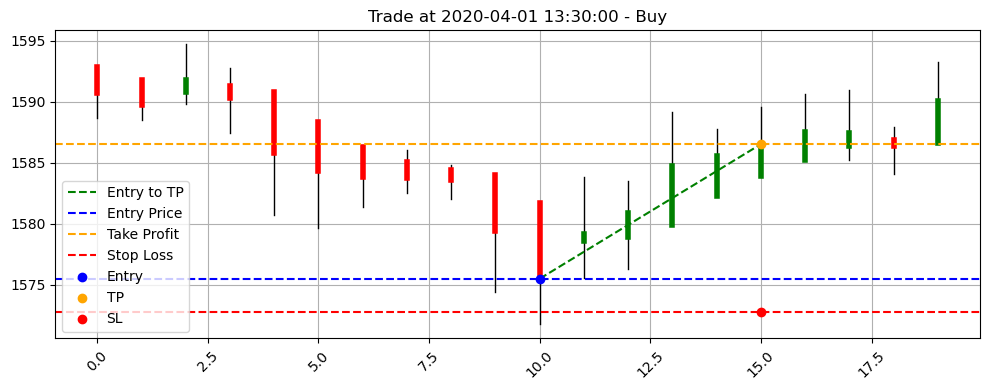

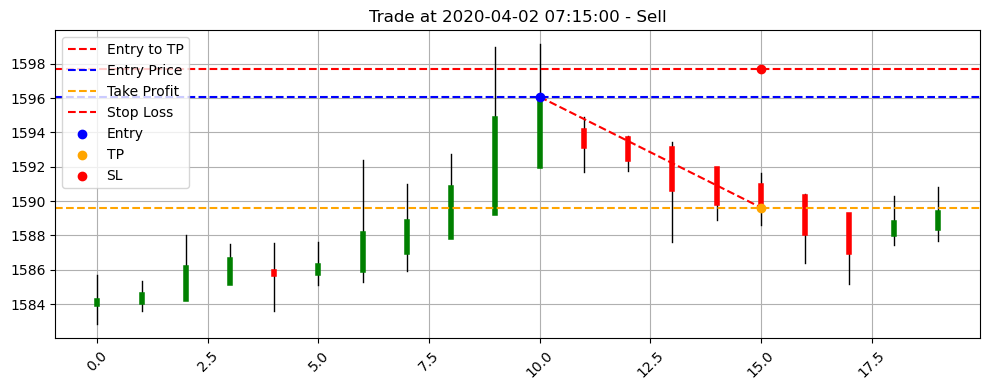

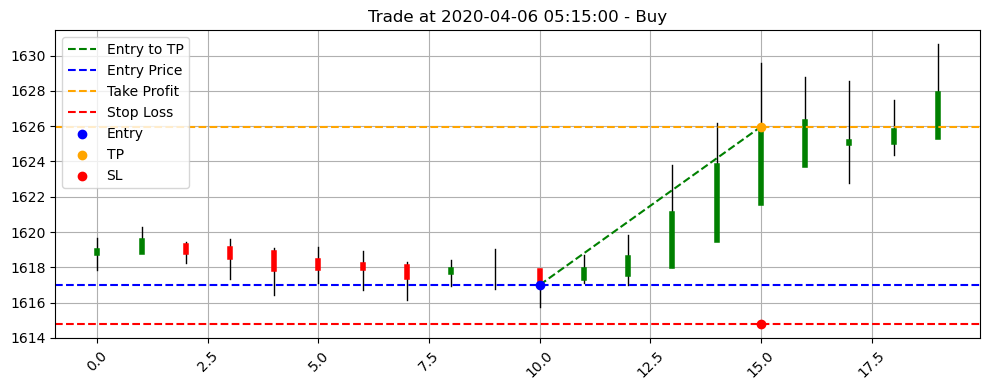

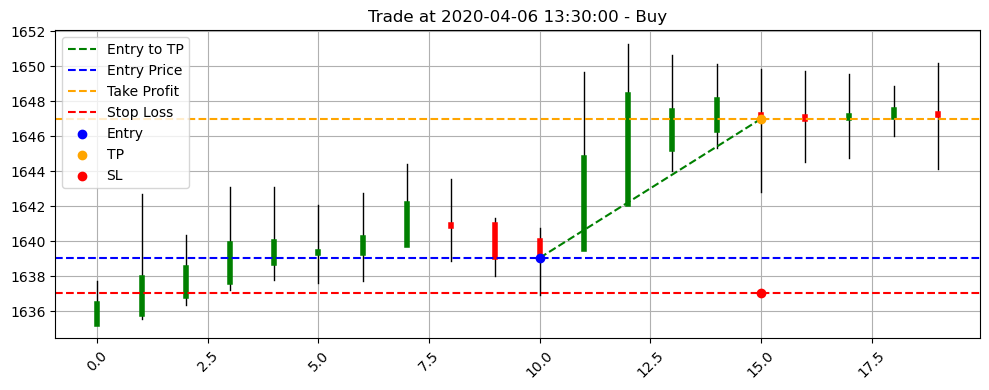

In [17]:
plot_trade_samples_with_sl_tp(ha_df, num_samples=100, candle_window=10)


In [19]:
import pandas as pd

# --- تأكد من تنسيق الأعمدة الزمنية ---
ha_df['Gmt time'] = pd.to_datetime(ha_df['Gmt time'])
ha_df['Date'] = ha_df['Gmt time'].dt.date
ha_df['Weekday'] = ha_df['Gmt time'].dt.dayofweek  # 0=الاثنين, ..., 6=الأحد

# --- تصفية الصفقات الفعلية ---
actual_trades = ha_df[ha_df['Signal'] != 0]

# --- 1. عدد الصفقات الكلي ---
total_trades = len(actual_trades)
print(f"✅ عدد الصفقات الكلي: {total_trades}")

# --- 2. عدد إشارات الشراء والبيع ---
print("\n📊 توزيع الإشارات:")
print(actual_trades['Signal'].value_counts())

# --- 3. عدد الأيام الكلية في البيانات ---
unique_days = ha_df['Date'].nunique()
print(f"\n📆 عدد الأيام الكلية: {unique_days}")

# --- 4. عدد الأيام التي بها صفقات ---
days_with_trades = actual_trades['Date'].nunique()
print(f"📈 عدد الأيام التي بها صفقات: {days_with_trades}")

# --- 5. استخراج الأيام التي ليست سبت أو أحد ---
valid_weekdays = ha_df[ha_df['Weekday'] < 5]['Date'].unique()  # أيام العمل فقط
trade_days = actual_trades['Date'].unique()
no_trade_days = sorted(set(valid_weekdays) - set(trade_days))
print(f"🚫 عدد الأيام بلا صفقات (باستثناء السبت والأحد): {len(no_trade_days)}")

# --- 6. تفاصيل الأيام التي بلا صفقات ---
if no_trade_days:
    print("\n🗓️ الأيام التي لم يكن بها صفقات (بخلاف العطلات):")
    for d in no_trade_days:
        print(f"- {d}")
else:
    print("\n✅ لا توجد أيام بلا صفقات خلال أيام العمل.")

# --- 7. إحصائيات عن عدد الصفقات اليومية ---
daily_trade_counts = actual_trades.groupby('Date').size()
print("\n📈 إحصائيات عدد الصفقات في اليوم:")
print(daily_trade_counts.describe())

# --- 8. اليوم الأكثر نشاطًا ---
if not daily_trade_counts.empty:
    most_active_day = daily_trade_counts.idxmax()
    max_signals = daily_trade_counts.max()
    print(f"\n🔥 أكثر يوم نشاطًا: {most_active_day} بعدد صفقات: {max_signals}")


✅ عدد الصفقات الكلي: 1443

📊 توزيع الإشارات:
Signal
 1    769
-1    674
Name: count, dtype: int64

📆 عدد الأيام الكلية: 1768
📈 عدد الأيام التي بها صفقات: 814
🚫 عدد الأيام بلا صفقات (باستثناء السبت والأحد): 511

🗓️ الأيام التي لم يكن بها صفقات (بخلاف العطلات):
- 2020-01-01
- 2020-01-02
- 2020-01-09
- 2020-01-10
- 2020-01-13
- 2020-01-14
- 2020-01-15
- 2020-01-16
- 2020-01-17
- 2020-01-20
- 2020-01-22
- 2020-01-23
- 2020-01-24
- 2020-01-29
- 2020-01-30
- 2020-01-31
- 2020-02-05
- 2020-02-06
- 2020-02-10
- 2020-02-12
- 2020-02-13
- 2020-02-14
- 2020-02-17
- 2020-02-19
- 2020-02-20
- 2020-03-20
- 2020-03-25
- 2020-03-30
- 2020-03-31
- 2020-04-03
- 2020-04-24
- 2020-04-27
- 2020-04-28
- 2020-05-01
- 2020-05-07
- 2020-05-13
- 2020-05-18
- 2020-05-20
- 2020-05-22
- 2020-05-25
- 2020-05-26
- 2020-05-29
- 2020-06-02
- 2020-06-03
- 2020-06-04
- 2020-06-08
- 2020-06-10
- 2020-06-12
- 2020-06-16
- 2020-06-17
- 2020-06-19
- 2020-06-23
- 2020-06-29
- 2020-06-30
- 2020-07-01
- 2020-07-03
- 2020-07-06

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 10, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 64)                │          17,920 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           4,160 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ signal (Dense)                │ (None, 3)                 │             195 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tp (Dense)                    │ (None, 1)                 │              65 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sl (Dense)                    │ (None, 1)                 │              65 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 22,405 (87.52 KB)

 Trainable params: 22,405 (87.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 8089032.5000 - signal_accuracy: 0.1953 - signal_loss: 1.1198 - sl_loss: 4045710.5000 - tp_loss: 4043342.7500 - val_loss: 8100189.0000 - val_signal_accuracy: 0.4808 - val_signal_loss: 1.1150 - val_sl_loss: 4049326.2500 - val_tp_loss: 4051433.0000
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8105962.5000 - signal_accuracy: 0.4718 - signal_loss: 0.9274 - sl_loss: 4051733.2500 - tp_loss: 4054401.0000 - val_loss: 7928838.0000 - val_signal_accuracy: 0.4808 - val_signal_loss: 0.7141 - val_sl_loss: 3958986.7500 - val_tp_loss: 3970417.0000
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7720085.5000 - signal_accuracy: 0.4949 - signal_loss: 0.7174 - sl_loss: 3854811.5000 - tp_loss: 3865069.0000 - val_loss: 7690332.0000 - val_signal_accuracy: 0.5192 - val_signal_loss: 0.6953 - val_sl_loss: 3835568.0000 - val_tp_loss: 3855321.7500
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7686921.0000 - signal_accu

C:\Users\Access\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


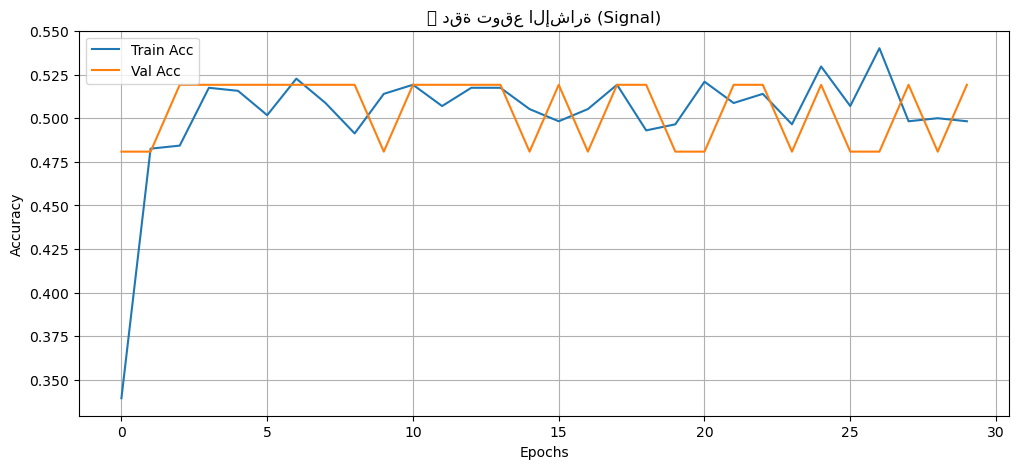

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# ---------------------------
# 1. توليد الإشارات الدقيقة
# ---------------------------

def generate_strict_signals(df, steps_ahead=5, min_target_points=5.0, rr_ratio=4.0):
    signals = []
    take_profits = []
    stop_losses = []

    close = df['Close'].values
    high = df['High'].values
    low = df['Low'].values
    times = pd.to_datetime(df['Gmt time']).values

    for i in range(len(df) - steps_ahead):
        entry_price = close[i]
        entry_day = pd.to_datetime(times[i]).date()
        future_day = pd.to_datetime(times[i + steps_ahead]).date()

        if entry_day != future_day:
            signals.append(0)
            take_profits.append(None)
            stop_losses.append(None)
            continue

        signal = 0
        tp = None
        sl = None

        future_close = close[i + steps_ahead]
        future_high = high[i+1 : i+steps_ahead+1]
        future_low = low[i+1 : i+steps_ahead+1]

        # شراء
        if future_close > entry_price:
            min_low = future_low.min()
            retraced = min_low < entry_price
            target = future_close - entry_price
            if not retraced and target >= min_target_points:
                signal = 1
                tp = entry_price + target
                sl = entry_price - (target / rr_ratio)

        # بيع
        elif future_close < entry_price:
            max_high = future_high.max()
            retraced = max_high > entry_price
            target = entry_price - future_close
            if not retraced and target >= min_target_points:
                signal = -1
                tp = entry_price - target
                sl = entry_price + (target / rr_ratio)

        signals.append(signal)
        take_profits.append(tp)
        stop_losses.append(sl)

    for _ in range(steps_ahead):
        signals.append(0)
        take_profits.append(None)
        stop_losses.append(None)

    df['Signal'] = signals
    df['Take_Profit'] = take_profits
    df['Stop_Loss'] = stop_losses

    return df

# ---------------------------
# 2. تجهيز البيانات
# ---------------------------

# تأكد من أن df يحتوي على الأعمدة: Gmt time, Open, High, Low, Close, Volume
df = generate_strict_signals(df)  # ← طبق الاستراتيجية

df = df.dropna(subset=['Take_Profit', 'Stop_Loss'])  # إزالة الصفقات غير الصالحة

features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

# ---------------------------
# 3. sliding window
# ---------------------------

lookback = 10
X, y_signal, y_tp, y_sl = [], [], [], []

for i in range(len(df) - lookback):
    X.append(scaled_features[i:i+lookback])
    y_signal.append(df['Signal'].iloc[i + lookback])
    y_tp.append(df['Take_Profit'].iloc[i + lookback])
    y_sl.append(df['Stop_Loss'].iloc[i + lookback])

X = np.array(X)
y_signal = to_categorical(np.array([s + 1 for s in y_signal]), num_classes=3)  # تحويل -1,0,1 إلى 0,1,2
y_tp = np.array(y_tp).reshape(-1, 1)
y_sl = np.array(y_sl).reshape(-1, 1)

# ---------------------------
# 4. تقسيم البيانات
# ---------------------------

X_train, X_test, y_signal_train, y_signal_test, y_tp_train, y_tp_test, y_sl_train, y_sl_test = train_test_split(
    X, y_signal, y_tp, y_sl, test_size=0.2, random_state=42)

# ---------------------------
# 5. بناء نموذج LSTM متعدد المخارج
# ---------------------------

input_layer = Input(shape=(lookback, len(features)))
lstm_out = LSTM(64, return_sequences=False)(input_layer)
dense = Dense(64, activation='relu')(lstm_out)

signal_output = Dense(3, activation='softmax', name='signal')(dense)
tp_output = Dense(1, activation='linear', name='tp')(dense)
sl_output = Dense(1, activation='linear', name='sl')(dense)

model = Model(inputs=input_layer, outputs=[signal_output, tp_output, sl_output])
model.compile(
    optimizer='adam',
    loss={'signal': 'categorical_crossentropy', 'tp': 'mse', 'sl': 'mse'},
    metrics={'signal': 'accuracy'}
)

model.summary()

# ---------------------------
# 6. تدريب النموذج
# ---------------------------

history = model.fit(
    X_train,
    {'signal': y_signal_train, 'tp': y_tp_train, 'sl': y_sl_train},
    validation_data=(X_test, {'signal': y_signal_test, 'tp': y_tp_test, 'sl': y_sl_test}),
    epochs=30,
    batch_size=32
)

# ---------------------------
# 7. رسم أداء النموذج
# ---------------------------

plt.figure(figsize=(12, 5))
plt.plot(history.history['signal_accuracy'], label='Train Acc')
plt.plot(history.history['val_signal_accuracy'], label='Val Acc')
plt.title("📈 دقة توقع الإشارة (Signal)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
